# Experiments

In [1]:
#!pip install matplotlib
#!pip install pandas
#!pip install tqdm

# code for importing from src
import os
os.chdir('../') # change working directory to the root of the project
# install package in editable mode
!pip install -e . 
os.chdir('src') # change working directory back to src

Obtaining file:///C:/Users/choho/Desktop/Master%20DS/Deep%20learning%20II/github/DeepLearning2-Project-M2DS
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for generative_model (pyproject.toml): started
  Building editable for generative_model (pyproject.toml): finished with status 'done'
  Created wheel for generative_model: filename=generative_model-0.1-0.editable-py3-none-any.whl size=13944 sha256=3a062fca1c7bbb080d1da3

In [2]:
# Import.
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from models.rbm import RBM
from models.dbn import DBN
from models.dnn import DNN
from utils import (
    load_mnist,
    load_alphadigit,
    read_alpha_digit,
    plot_characters_alphadigit,
    plot_generated_images
)

In [3]:
DATA_FOLDER = "../data/"
ALPHA_DIGIT_PATH = os.path.join(DATA_FOLDER, "binaryalphadigs.mat")
MNIST_PATH = os.path.join(DATA_FOLDER, "mnist_all.mat")

for path in [ALPHA_DIGIT_PATH, MNIST_PATH]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file {path} does not exist.")

SEED = 42

## 1. Study on BinaryAlphaDigit

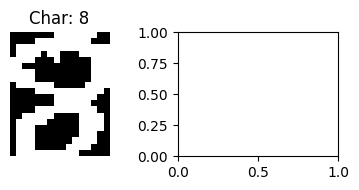

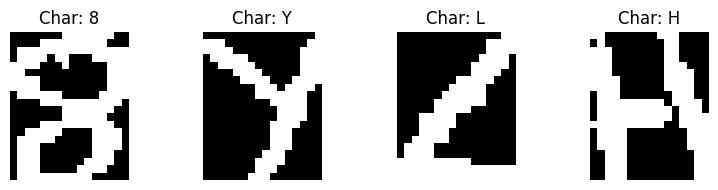

Original data: (36, 39)
Original data (unstack samples -> flatten images): (1365, 320)
Subset (1 character) data  (39, 320)
Subset (4 characters) data  (156, 320)


In [4]:
alphadigit = load_alphadigit(ALPHA_DIGIT_PATH)

chars_1 = [8]
chars_2 = chars_1 + ["Y"]
chars_3 = chars_2 + ["L"]
chars_4 = chars_3 + ["H"]
data_alpha_1 = read_alpha_digit(chars_1, data=alphadigit, use_data=True)
data_alpha_2 = read_alpha_digit(chars_2, data=alphadigit, use_data=True)
data_alpha_3 = read_alpha_digit(chars_3, data=alphadigit, use_data=True)
data_alpha_4 = read_alpha_digit(chars_4, data=alphadigit, use_data=True)

all_chars = np.arange(0, 35).tolist()
alphadigit_data = read_alpha_digit(all_chars, data=alphadigit, use_data=True) # read all characters

plot_characters_alphadigit(chars_1, data_alpha_1)
plot_characters_alphadigit(chars_4, data_alpha_4)

print("Original data:", alphadigit.shape)
print("Original data (unstack samples -> flatten images):", alphadigit_data.shape)
print(f"Subset ({len(chars_1)} character) data ", data_alpha_1.shape)
print(f"Subset ({len(chars_4)} characters) data ", data_alpha_4.shape)

### RBM

In [5]:
data_alpha = data_alpha_1
n_chars = data_alpha.shape[0] / 39

# Parameters
n_visible = data_alpha.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)
learning_rate = 0.1
n_epochs = 100
batch_size = int(8 * n_chars)

# Initialize RBM
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, random_state=SEED)
print(rbm)

# Train RBM
rbm.train(data_alpha, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size)

RBM(n_visible=320, n_hidden=200)


[0.2288,
 0.2056,
 0.2133,
 0.1863,
 0.184,
 0.1968,
 0.1862,
 0.1958,
 0.1735,
 0.1743,
 0.1879,
 0.1706,
 0.1564,
 0.1766,
 0.2011,
 0.158,
 0.199,
 0.1701,
 0.1641,
 0.2054,
 0.1746,
 0.1632,
 0.1348,
 0.1765,
 0.1417,
 0.1458,
 0.1404,
 0.1551,
 0.1345,
 0.1524,
 0.1437,
 0.1504,
 0.1596,
 0.1386,
 0.1311,
 0.1637,
 0.1363,
 0.1458,
 0.1603,
 0.1189,
 0.1173,
 0.1593,
 0.139,
 0.1317,
 0.1056,
 0.1481,
 0.1592,
 0.1063,
 0.1248,
 0.1268,
 0.1116,
 0.1078,
 0.1205,
 0.1015,
 0.1327,
 0.1222,
 0.1075,
 0.1284,
 0.1265,
 0.1534,
 0.0935,
 0.1138,
 0.1276,
 0.1299,
 0.1148,
 0.1249,
 0.1166,
 0.1173,
 0.1166,
 0.0965,
 0.1311,
 0.0987,
 0.109,
 0.1126,
 0.0896,
 0.1041,
 0.1231,
 0.1066,
 0.1022,
 0.1061,
 0.1104,
 0.1105,
 0.1055,
 0.1173,
 0.1136,
 0.1335,
 0.1006,
 0.1049,
 0.1133,
 0.1184,
 0.1014,
 0.1317,
 0.1081,
 0.0904,
 0.1172,
 0.085,
 0.1171,
 0.1191,
 0.1051,
 0.1293]

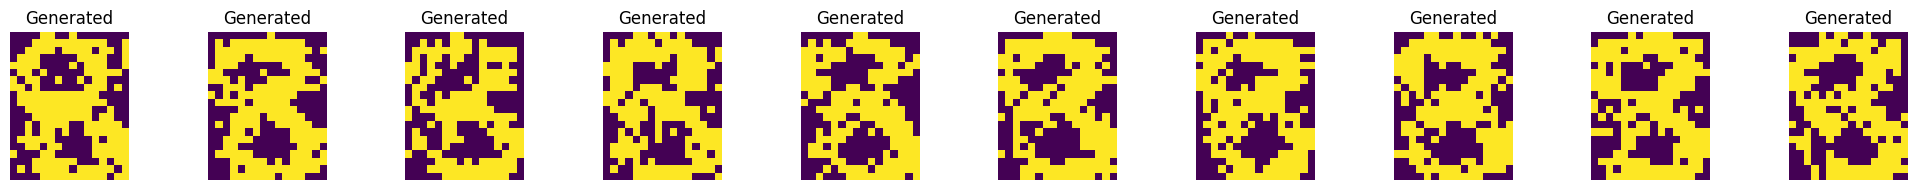

In [6]:
# Generate samples
generated_samples = rbm.generate_image(n_samples=10, n_gibbs_steps=1)

plot_generated_images(generated_samples, **{"cmap":None})

### DBN

In [7]:
data_alpha = data_alpha_1
n_chars = data_alpha.shape[0] / 39

# Parameters
n_visible = data_alpha.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)
hidden_layer_sizes = [200, 200, 200]

learning_rate = 0.1
n_epochs = 100
batch_size = int(8 * n_chars)

dbn = DBN(n_visible=n_visible, hidden_layer_sizes=hidden_layer_sizes, random_state=SEED)
dbn.train(data_alpha, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size)

Training RBM layers: 100%|██████████| 3/3 [00:02<00:00,  1.07layer/s]


([0.2288,
  0.2056,
  0.2133,
  0.1863,
  0.184,
  0.1968,
  0.1862,
  0.1958,
  0.1735,
  0.1743,
  0.1879,
  0.1706,
  0.1564,
  0.1766,
  0.2011,
  0.158,
  0.199,
  0.1701,
  0.1641,
  0.2054,
  0.1746,
  0.1632,
  0.1348,
  0.1765,
  0.1417,
  0.1458,
  0.1404,
  0.1551,
  0.1345,
  0.1524,
  0.1437,
  0.1504,
  0.1596,
  0.1386,
  0.1311,
  0.1637,
  0.1363,
  0.1458,
  0.1603,
  0.1189,
  0.1173,
  0.1593,
  0.139,
  0.1317,
  0.1056,
  0.1481,
  0.1592,
  0.1063,
  0.1248,
  0.1268,
  0.1116,
  0.1078,
  0.1205,
  0.1015,
  0.1327,
  0.1222,
  0.1075,
  0.1284,
  0.1265,
  0.1534,
  0.0935,
  0.1138,
  0.1276,
  0.1299,
  0.1148,
  0.1249,
  0.1166,
  0.1173,
  0.1166,
  0.0965,
  0.1311,
  0.0987,
  0.109,
  0.1126,
  0.0896,
  0.1041,
  0.1231,
  0.1066,
  0.1022,
  0.1061,
  0.1104,
  0.1105,
  0.1055,
  0.1173,
  0.1136,
  0.1335,
  0.1006,
  0.1049,
  0.1133,
  0.1184,
  0.1014,
  0.1317,
  0.1081,
  0.0904,
  0.1172,
  0.085,
  0.1171,
  0.1191,
  0.1051,
  0.1293,
  0.00

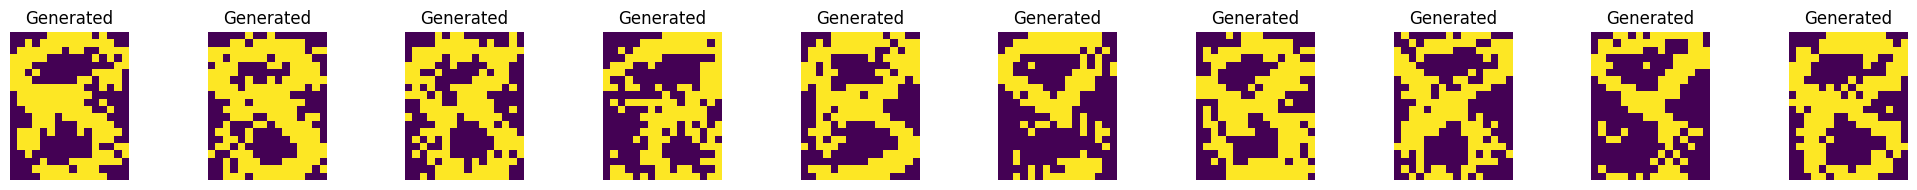

In [8]:
# # Generate images
generated_images = dbn.generate_image(n_samples=10, n_gibbs_steps=1)

# Display generated images
plot_generated_images(generated_images, **{"cmap":None})

### MNIST

In [9]:
import scipy.io

In [10]:
def load_mnist(mnist_path, mnist_dict=None, use_dict=False):
    if not use_dict:
        mnist_dict = scipy.io.loadmat(mnist_path)
    
    X_train = np.concatenate([mnist_dict[f"train{i}"] for i in range(10)], axis=0)
    X_test = np.concatenate([mnist_dict[f"test{i}"] for i in range(10)], axis=0)
    
    y_train = np.concatenate([np.eye(10)[[i]*mnist_dict[f"train{i}"].shape[0]] for i in range(10)], axis=0)
    y_test = np.concatenate([np.eye(10)[[i]*mnist_dict[f"test{i}"].shape[0]] for i in range(10)], axis=0)

    return X_train, y_train, X_test, y_test


def sample_indices(data_size: int, sample_size: int, random_state=None) -> np.ndarray:
    """
    Randomly sample indices from the range [0, data_size) without replacement.

    Parameters:
        data_size (int): Total number of indices available.
        sample_size (int): Number of indices to sample.
        random_state: Random seed for reproducibility.

    Returns:
        numpy.ndarray: Array of sampled indices.
    """
    rng = np.random.default_rng(random_state)
    if sample_size >= data_size:
        return np.arange(data_size)

    sampled_indices = rng.choice(data_size, size=sample_size, replace=False)
    return sampled_indices

def sample_mnist(X_train: np.ndarray, y_train: np.ndarray, sample_size: int, random_state=None) -> tuple:
    """
    Randomly sample a subset of samples from the MNIST dataset.

    Parameters:
        X_train (numpy.ndarray): Training data.
        y_train (numpy.ndarray): Training labels.
        sample_size (int): Number of samples to sample.
        random_state: Random seed for reproducibility.

    Returns:
        tuple: Sampled subset of training data and labels.
    """
    # Sample indices
    indices = sample_indices(len(X_train), sample_size, random_state=random_state)
    
    # Sample data and labels
    sampled_X_train = X_train[indices]
    sampled_y_train = y_train[indices]
    
    return sampled_X_train, sampled_y_train


def binarize_images(images):
    threshold = 127
    binary_images = np.where(images > threshold, 1, 0)
    return binary_images

mnist_train, mnist_train_labels, mnist_test, mnist_test_labels = (
    load_mnist(MNIST_PATH)
)


# Binarize the images
binary_mnist_train = binarize_images(mnist_train)
binary_mnist_test = binarize_images(mnist_test)


[mnist.shape for mnist in (mnist_train, mnist_train_labels, mnist_test, mnist_test_labels)]

[(60000, 784), (60000, 10), (10000, 784), (10000, 10)]

In [11]:
mnist_train_30000, mnist_train_labels_30000 = sample_mnist(mnist_train, mnist_train_labels, 30_000, 42)
mnist_train_30000.shape, mnist_train_labels_30000.shape

((30000, 784), (30000, 10))

In [12]:
print(mnist_train.max(), binary_mnist_train.max())

255 1


MNIST (60000, 28, 28)


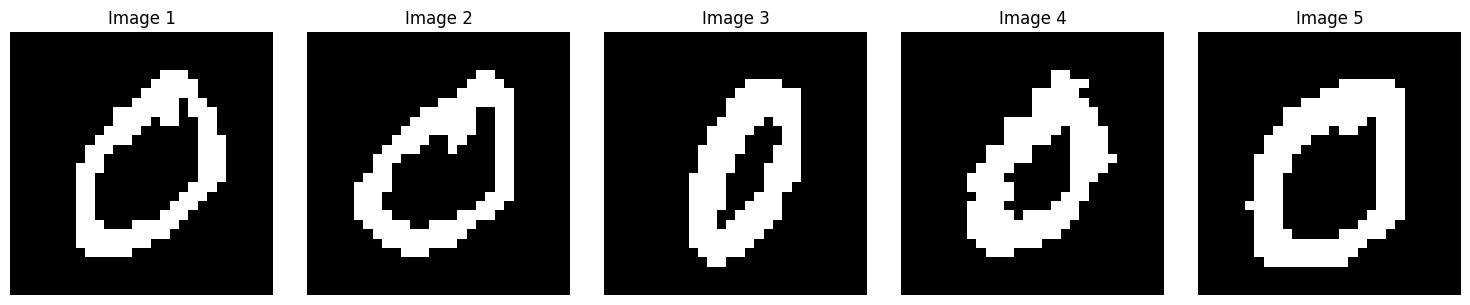

In [13]:
# Reshape mnist_train to its original shape
image_height = 28
image_width = 28
num_samples = binary_mnist_train.shape[0]
binary_mnist_train_images = binary_mnist_train.reshape(num_samples, image_height, image_width)
print("MNIST", binary_mnist_train_images.shape)

# Plot some images from mnist_train
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))
for i in range(num_images_to_plot):
    axes[i].imshow(binary_mnist_train_images[i], cmap='gray')
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [14]:
help(DNN)

Help on class DNN in module models.dnn:

class DNN(models.dbn.DBN)
 |  DNN(input_dim: int, output_dim: int, hidden_layer_sizes: List[int], random_state=None)
 |  
 |  Method resolution order:
 |      DNN
 |      models.dbn.DBN
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, key)
 |  
 |  __init__(self, input_dim: int, output_dim: int, hidden_layer_sizes: List[int], random_state=None)
 |      Initialize the Deep Neural Network (DNN).
 |      
 |      Parameters:
 |      - input_dim (int): Dimension of the input.
 |      - output_dim (int): Dimension of the output.
 |      - hidden_layer_sizes (List[int]): List of sizes for each hidden layer.
 |      - random_state: Random seed for reproducibility.
 |  
 |  __len__(self)
 |  
 |  __repr__(self)
 |      Return a string representation of the DBN object.
 |  
 |  backpropagation(self, input_data: numpy.ndarray, labels: numpy.ndarray, n_epochs: int = 100, learning_rate: float = 0.1, batch_size: int = 10, eps

# 0.Verify that DNN work well

Training:   1%|          | 1/100 [00:04<06:43,  4.08s/epoch]

Epoch 1/100, Cross Entropy: 1.8801176847831995


Training:   2%|▏         | 2/100 [00:08<06:35,  4.03s/epoch]

Epoch 2/100, Cross Entropy: 1.3738578301393412


Training:   3%|▎         | 3/100 [00:11<06:20,  3.93s/epoch]

Epoch 3/100, Cross Entropy: 1.2445853939108107


Training:   4%|▍         | 4/100 [00:16<06:26,  4.03s/epoch]

Epoch 4/100, Cross Entropy: 1.1968095759522615


Training:   5%|▌         | 5/100 [00:19<06:13,  3.94s/epoch]

Epoch 5/100, Cross Entropy: 1.1737903659902986


Training:   6%|▌         | 6/100 [00:23<06:16,  4.00s/epoch]

Epoch 6/100, Cross Entropy: 1.163332031301917


Training:   7%|▋         | 7/100 [00:27<06:04,  3.92s/epoch]

Epoch 7/100, Cross Entropy: 1.1495484192888554


Training:   8%|▊         | 8/100 [00:30<05:41,  3.71s/epoch]

Epoch 8/100, Cross Entropy: 1.1416592395775602


Training:   9%|▉         | 9/100 [00:34<05:30,  3.63s/epoch]

Epoch 9/100, Cross Entropy: 1.1442286821416654


Training:  10%|█         | 10/100 [00:38<05:37,  3.75s/epoch]

Epoch 10/100, Cross Entropy: 1.126230294364031


Training:  11%|█         | 11/100 [00:42<05:36,  3.78s/epoch]

Epoch 11/100, Cross Entropy: 1.1419021970936944


Training:  12%|█▏        | 12/100 [00:46<05:38,  3.85s/epoch]

Epoch 12/100, Cross Entropy: 1.13627647233082


Training:  13%|█▎        | 13/100 [00:50<05:44,  3.96s/epoch]

Epoch 13/100, Cross Entropy: 1.133585783303416


Training:  14%|█▍        | 14/100 [00:54<05:47,  4.04s/epoch]

Epoch 14/100, Cross Entropy: 1.1297739088148484


Training:  15%|█▌        | 15/100 [00:58<05:36,  3.96s/epoch]

Epoch 15/100, Cross Entropy: 1.1296877854081169


Training:  16%|█▌        | 16/100 [01:01<05:15,  3.76s/epoch]

Epoch 16/100, Cross Entropy: 1.1343510644633403


Training:  17%|█▋        | 17/100 [01:05<05:11,  3.75s/epoch]

Epoch 17/100, Cross Entropy: 1.1318655577297536


Training:  18%|█▊        | 18/100 [01:09<05:00,  3.67s/epoch]

Epoch 18/100, Cross Entropy: 1.1371842260573966


Training:  19%|█▉        | 19/100 [01:12<04:46,  3.54s/epoch]

Epoch 19/100, Cross Entropy: 1.1374307819537386


Training:  20%|██        | 20/100 [01:15<04:39,  3.49s/epoch]

Epoch 20/100, Cross Entropy: 1.1381971091326284


Training:  21%|██        | 21/100 [01:19<04:33,  3.46s/epoch]

Epoch 21/100, Cross Entropy: 1.1386446380594508


Training:  22%|██▏       | 22/100 [01:22<04:25,  3.41s/epoch]

Epoch 22/100, Cross Entropy: 1.1331187352400633


Training:  23%|██▎       | 23/100 [01:25<04:18,  3.35s/epoch]

Epoch 23/100, Cross Entropy: 1.1449536021588598


Training:  24%|██▍       | 24/100 [01:28<04:13,  3.33s/epoch]

Epoch 24/100, Cross Entropy: 1.1405061058906756


Training:  25%|██▌       | 25/100 [01:31<04:06,  3.29s/epoch]

Epoch 25/100, Cross Entropy: 1.1341592430613427


Training:  26%|██▌       | 26/100 [01:35<04:00,  3.25s/epoch]

Epoch 26/100, Cross Entropy: 1.133915929600394


Training:  27%|██▋       | 27/100 [01:38<03:52,  3.19s/epoch]

Epoch 27/100, Cross Entropy: 1.1336933681735013


Training:  28%|██▊       | 28/100 [01:41<03:45,  3.13s/epoch]

Epoch 28/100, Cross Entropy: 1.129855135930918


Training:  29%|██▉       | 29/100 [01:44<03:43,  3.15s/epoch]

Epoch 29/100, Cross Entropy: 1.1350859025842606


Training:  30%|███       | 30/100 [01:47<03:42,  3.18s/epoch]

Epoch 30/100, Cross Entropy: 1.1338423272459854


Training:  31%|███       | 31/100 [01:51<03:45,  3.27s/epoch]

Epoch 31/100, Cross Entropy: 1.1369841816543633


Training:  32%|███▏      | 32/100 [01:54<03:38,  3.22s/epoch]

Epoch 32/100, Cross Entropy: 1.133190787994968


Training:  33%|███▎      | 33/100 [01:57<03:40,  3.29s/epoch]

Epoch 33/100, Cross Entropy: 1.1358275507613036


Training:  34%|███▍      | 34/100 [02:00<03:36,  3.28s/epoch]

Epoch 34/100, Cross Entropy: 1.1334566028634567


Training:  35%|███▌      | 35/100 [02:04<03:37,  3.35s/epoch]

Epoch 35/100, Cross Entropy: 1.1353948180366413


Training:  36%|███▌      | 36/100 [02:07<03:33,  3.33s/epoch]

Epoch 36/100, Cross Entropy: 1.136642715960676


Training:  37%|███▋      | 37/100 [02:10<03:27,  3.29s/epoch]

Epoch 37/100, Cross Entropy: 1.1294191100239244


Training:  38%|███▊      | 38/100 [02:13<03:19,  3.22s/epoch]

Epoch 38/100, Cross Entropy: 1.1321053354470116


Training:  39%|███▉      | 39/100 [02:17<03:13,  3.18s/epoch]

Epoch 39/100, Cross Entropy: 1.1317211282542772


Training:  40%|████      | 40/100 [02:20<03:08,  3.14s/epoch]

Epoch 40/100, Cross Entropy: 1.1381604049949876


Training:  41%|████      | 41/100 [02:23<03:04,  3.13s/epoch]

Epoch 41/100, Cross Entropy: 1.1383711688570128


Training:  42%|████▏     | 42/100 [02:26<02:55,  3.02s/epoch]

Epoch 42/100, Cross Entropy: 1.1344704208396703


Training:  43%|████▎     | 43/100 [02:28<02:50,  3.00s/epoch]

Epoch 43/100, Cross Entropy: 1.1363711089009758


Training:  44%|████▍     | 44/100 [02:32<02:50,  3.05s/epoch]

Epoch 44/100, Cross Entropy: 1.1389682082507184


Training:  45%|████▌     | 45/100 [02:35<02:50,  3.11s/epoch]

Epoch 45/100, Cross Entropy: 1.1341327841461262


Training:  46%|████▌     | 46/100 [02:38<02:46,  3.08s/epoch]

Epoch 46/100, Cross Entropy: 1.1378993980550103


Training:  47%|████▋     | 47/100 [02:41<02:48,  3.19s/epoch]

Epoch 47/100, Cross Entropy: 1.1392799354716372


Training:  48%|████▊     | 48/100 [02:45<02:55,  3.37s/epoch]

Epoch 48/100, Cross Entropy: 1.130932487285503


Training:  49%|████▉     | 49/100 [02:49<02:58,  3.50s/epoch]

Epoch 49/100, Cross Entropy: 1.135030940629755


Training:  50%|█████     | 50/100 [02:52<02:52,  3.45s/epoch]

Epoch 50/100, Cross Entropy: 1.134460706844424


Training:  51%|█████     | 51/100 [02:56<02:49,  3.47s/epoch]

Epoch 51/100, Cross Entropy: 1.138790384786377


Training:  52%|█████▏    | 52/100 [02:59<02:46,  3.47s/epoch]

Epoch 52/100, Cross Entropy: 1.1289587718805048


Training:  53%|█████▎    | 53/100 [03:02<02:39,  3.39s/epoch]

Epoch 53/100, Cross Entropy: 1.1313112157228542


Training:  54%|█████▍    | 54/100 [03:06<02:35,  3.38s/epoch]

Epoch 54/100, Cross Entropy: 1.1359013218356735


Training:  55%|█████▌    | 55/100 [03:10<02:36,  3.49s/epoch]

Epoch 55/100, Cross Entropy: 1.1361320618772448


Training:  56%|█████▌    | 56/100 [03:14<02:43,  3.72s/epoch]

Epoch 56/100, Cross Entropy: 1.1384966214773036


Training:  57%|█████▋    | 57/100 [03:18<02:47,  3.89s/epoch]

Epoch 57/100, Cross Entropy: 1.13565234903598


Training:  58%|█████▊    | 58/100 [03:22<02:42,  3.88s/epoch]

Epoch 58/100, Cross Entropy: 1.1336598499497081


Training:  59%|█████▉    | 59/100 [03:26<02:39,  3.89s/epoch]

Epoch 59/100, Cross Entropy: 1.1393550178019851


Training:  60%|██████    | 60/100 [03:30<02:32,  3.82s/epoch]

Epoch 60/100, Cross Entropy: 1.1321863067884068


Training:  61%|██████    | 61/100 [03:33<02:30,  3.87s/epoch]

Epoch 61/100, Cross Entropy: 1.1326987529999812


Training:  62%|██████▏   | 62/100 [03:37<02:25,  3.83s/epoch]

Epoch 62/100, Cross Entropy: 1.129810181254043


Training:  63%|██████▎   | 63/100 [03:41<02:22,  3.85s/epoch]

Epoch 63/100, Cross Entropy: 1.1302585837565586


Training:  64%|██████▍   | 64/100 [03:45<02:20,  3.91s/epoch]

Epoch 64/100, Cross Entropy: 1.1366577800356439


Training:  65%|██████▌   | 65/100 [03:49<02:15,  3.86s/epoch]

Epoch 65/100, Cross Entropy: 1.1328186790027415


Training:  66%|██████▌   | 66/100 [03:53<02:13,  3.92s/epoch]

Epoch 66/100, Cross Entropy: 1.1338998578474995


Training:  67%|██████▋   | 67/100 [03:57<02:10,  3.96s/epoch]

Epoch 67/100, Cross Entropy: 1.1319500679659094


Training:  68%|██████▊   | 68/100 [04:01<02:05,  3.93s/epoch]

Epoch 68/100, Cross Entropy: 1.1323551699902379


Training:  69%|██████▉   | 69/100 [04:05<02:02,  3.96s/epoch]

Epoch 69/100, Cross Entropy: 1.1348439594366673


Training:  70%|███████   | 70/100 [04:09<01:57,  3.91s/epoch]

Epoch 70/100, Cross Entropy: 1.1378946568105213


Training:  71%|███████   | 71/100 [04:13<01:54,  3.95s/epoch]

Epoch 71/100, Cross Entropy: 1.1339843018776294


Training:  72%|███████▏  | 72/100 [04:17<01:49,  3.90s/epoch]

Epoch 72/100, Cross Entropy: 1.1345837437334203


Training:  73%|███████▎  | 73/100 [04:20<01:45,  3.91s/epoch]

Epoch 73/100, Cross Entropy: 1.133070951436432


Training:  74%|███████▍  | 74/100 [04:24<01:41,  3.90s/epoch]

Epoch 74/100, Cross Entropy: 1.1319710983925773


Training:  75%|███████▌  | 75/100 [04:28<01:37,  3.90s/epoch]

Epoch 75/100, Cross Entropy: 1.1331387034791975


Training:  76%|███████▌  | 76/100 [04:32<01:34,  3.94s/epoch]

Epoch 76/100, Cross Entropy: 1.137435099300768


Training:  77%|███████▋  | 77/100 [04:36<01:30,  3.95s/epoch]

Epoch 77/100, Cross Entropy: 1.1426091421430573


Training:  78%|███████▊  | 78/100 [04:40<01:26,  3.94s/epoch]

Epoch 78/100, Cross Entropy: 1.133141547699185


Training:  79%|███████▉  | 79/100 [04:44<01:22,  3.94s/epoch]

Epoch 79/100, Cross Entropy: 1.1399302455577496


Training:  80%|████████  | 80/100 [04:48<01:18,  3.92s/epoch]

Epoch 80/100, Cross Entropy: 1.1295414788029228


Training:  81%|████████  | 81/100 [04:52<01:15,  3.96s/epoch]

Epoch 81/100, Cross Entropy: 1.1336280951108078


Training:  82%|████████▏ | 82/100 [04:56<01:10,  3.91s/epoch]

Epoch 82/100, Cross Entropy: 1.134941731901634


Training:  83%|████████▎ | 83/100 [05:00<01:06,  3.91s/epoch]

Epoch 83/100, Cross Entropy: 1.130255856566189


Training:  84%|████████▍ | 84/100 [05:04<01:02,  3.92s/epoch]

Epoch 84/100, Cross Entropy: 1.1335878230848366


Training:  85%|████████▌ | 85/100 [05:08<00:59,  3.94s/epoch]

Epoch 85/100, Cross Entropy: 1.1320508475965674


Training:  86%|████████▌ | 86/100 [05:12<00:55,  3.93s/epoch]

Epoch 86/100, Cross Entropy: 1.1348537053508596


Training:  87%|████████▋ | 87/100 [05:16<00:51,  3.93s/epoch]

Epoch 87/100, Cross Entropy: 1.1300201972016979


Training:  88%|████████▊ | 88/100 [05:19<00:47,  3.94s/epoch]

Epoch 88/100, Cross Entropy: 1.1291717232322789


Training:  89%|████████▉ | 89/100 [05:23<00:43,  3.97s/epoch]

Epoch 89/100, Cross Entropy: 1.1340501637108011


Training:  90%|█████████ | 90/100 [05:27<00:38,  3.87s/epoch]

Epoch 90/100, Cross Entropy: 1.1380786601789787


Training:  91%|█████████ | 91/100 [05:31<00:35,  3.92s/epoch]

Epoch 91/100, Cross Entropy: 1.1315332889305971


Training:  92%|█████████▏| 92/100 [05:35<00:30,  3.87s/epoch]

Epoch 92/100, Cross Entropy: 1.1321783651497224


Training:  93%|█████████▎| 93/100 [05:39<00:27,  3.95s/epoch]

Epoch 93/100, Cross Entropy: 1.1319658603038272


Training:  94%|█████████▍| 94/100 [05:43<00:23,  3.95s/epoch]

Epoch 94/100, Cross Entropy: 1.12822841646024


Training:  95%|█████████▌| 95/100 [05:47<00:19,  3.96s/epoch]

Epoch 95/100, Cross Entropy: 1.1310460319363869


Training:  96%|█████████▌| 96/100 [05:51<00:15,  3.97s/epoch]

Epoch 96/100, Cross Entropy: 1.1322208953501345


Training:  97%|█████████▋| 97/100 [05:55<00:11,  3.98s/epoch]

Epoch 97/100, Cross Entropy: 1.1348550862720086


Training:  98%|█████████▊| 98/100 [05:59<00:07,  3.95s/epoch]

Epoch 98/100, Cross Entropy: 1.1304606780164823


Training:  99%|█████████▉| 99/100 [06:04<00:04,  4.16s/epoch]

Epoch 99/100, Cross Entropy: 1.1337746867934928


Training: 100%|██████████| 100/100 [06:07<00:00,  3.68s/epoch]


Epoch 100/100, Cross Entropy: 1.1341972677424734


c:\Users\choho\Desktop\Master DS\Deep learning II\github\DeepLearning2-Project-M2DS\src\functionals.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(0.20430000000000004, array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]]))


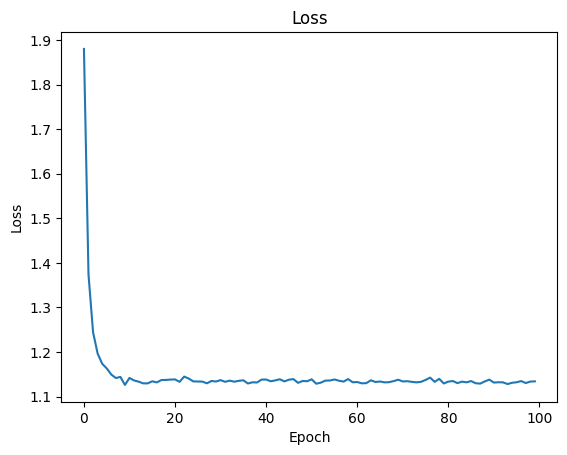

In [15]:
from copy import copy, deepcopy

data = mnist_train.copy()
n_samples, n_visible = data.shape # n_samples, n_features
n_visible = data.shape[1]
hidden_layer_sizes = [250]
n_classes = mnist_test_labels.shape[1]

dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)

losses_100 = dnn.backpropagation(binary_mnist_train, labels=mnist_train_labels, n_epochs=100, learning_rate=3e-4, batch_size=512)


print(dnn.test(binary_mnist_test, mnist_test_labels))

#plotter la loss à partir d'une liste de loss
plt.plot(losses_100)
plt.title("Loss")   
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [16]:
print(dnn.test(binary_mnist_test, mnist_test_labels))


(0.37470000000000003, array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]]))


# 1. Error rate according to varying layers numbers

In [18]:
import matplotlib.pyplot as plt
import pickle
import numpy as np


def save_object(obj, filename, output_dir):
    """
    Save a Python object to a file using pickle.

    Parameters:
    - obj: The Python object to save.
    - filename (str): The name of the file to save the object to.
    - output_dir (str): The directory where to save the file.
    """
    os.makedirs(output_dir, exist_ok=True)
    filepath = os.path.join(output_dir, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

def load_object(filename, output_dir):
    """
    Load a Python object from a file using pickle.

    Parameters:
    - filename (str): The name of the file to load the object from.
    - output_dir (str): The directory where the file is located.

    Returns:
    - The Python object loaded from the file.
    """
    filepath = os.path.join(output_dir, filename)
    with open(filepath, 'rb') as f:
        return pickle.load(f)

## 1.1. Without pretraining

In [20]:
n_samples, n_visible = mnist_train.shape # n_samples, n_features
n_classes = mnist_test_labels.shape[1]

layer_loss = []
layer_error_rate_train = []
layer_error_rate_test = []
for n_layers in [1, 2, 3, 4, 5]:
    hidden_layer_sizes = [256] * n_layers
    dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
    loss = dnn.backpropagation(binary_mnist_train, labels=mnist_train_labels, n_epochs=100, learning_rate=3e-4, batch_size=512)
    layer_loss.append(loss)
    
    error_rate_train, _ = dnn.test(test_data=binary_mnist_train, true_labels=mnist_train_labels)
    layer_error_rate_train.append(error_rate_train)  # Assurez-vous que error_rate_train est un scalaire

    error_rate_test, _ = dnn.test(test_data=binary_mnist_test, true_labels=mnist_test_labels)
    layer_error_rate_test.append(error_rate_test)  # Assurez-vous que error_rate_test est un scalaire

    # Save the lists with losses and error rates
    save_object(layer_loss, "layer_loss_" + str(n_layers) + ".pkl", output_dir="../results/experiments_mnist")
    save_object(layer_error_rate_train, "layer_error_rate_train_" + str(n_layers) + ".pkl",output_dir="../results/experiments_mnist")
    save_object(layer_error_rate_test, "layer_error_rate_test_" + str(n_layers) + ".pkl",output_dir="../results/experiments_mnist")


Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training:   1%|          | 1/100 [00:03<05:33,  3.37s/epoch]

Epoch 1/100, Cross Entropy: 1.8894495130492934


Training:   2%|▏         | 2/100 [00:06<05:34,  3.41s/epoch]

Epoch 2/100, Cross Entropy: 1.3622334863334205


Training:   3%|▎         | 3/100 [00:11<06:10,  3.82s/epoch]

Epoch 3/100, Cross Entropy: 1.2261330035747475


Training:   4%|▍         | 4/100 [00:14<06:05,  3.81s/epoch]

Epoch 4/100, Cross Entropy: 1.1810666422878717


Training:   5%|▌         | 5/100 [00:18<05:50,  3.69s/epoch]

Epoch 5/100, Cross Entropy: 1.1525038487495025


Training:   6%|▌         | 6/100 [00:21<05:43,  3.66s/epoch]

Epoch 6/100, Cross Entropy: 1.1451010907015398


Training:   7%|▋         | 7/100 [00:26<05:54,  3.81s/epoch]

Epoch 7/100, Cross Entropy: 1.1241728928470616


Training:   8%|▊         | 8/100 [00:29<05:44,  3.74s/epoch]

Epoch 8/100, Cross Entropy: 1.1297777638636135


Training:   9%|▉         | 9/100 [00:33<05:54,  3.89s/epoch]

Epoch 9/100, Cross Entropy: 1.1256656737570856


Training:  10%|█         | 10/100 [00:37<05:37,  3.75s/epoch]

Epoch 10/100, Cross Entropy: 1.1179058233789605


Training:  11%|█         | 11/100 [00:40<05:20,  3.60s/epoch]

Epoch 11/100, Cross Entropy: 1.123186789084615


Training:  12%|█▏        | 12/100 [00:44<05:15,  3.59s/epoch]

Epoch 12/100, Cross Entropy: 1.1252553041850064


Training:  13%|█▎        | 13/100 [00:47<05:16,  3.63s/epoch]

Epoch 13/100, Cross Entropy: 1.1229895217989136


Training:  14%|█▍        | 14/100 [00:51<05:20,  3.73s/epoch]

Epoch 14/100, Cross Entropy: 1.1193475053717734


Training:  15%|█▌        | 15/100 [00:55<05:16,  3.72s/epoch]

Epoch 15/100, Cross Entropy: 1.1232542396966028


Training:  16%|█▌        | 16/100 [00:59<05:15,  3.76s/epoch]

Epoch 16/100, Cross Entropy: 1.1208535687113863


Training:  17%|█▋        | 17/100 [01:02<05:05,  3.67s/epoch]

Epoch 17/100, Cross Entropy: 1.115237174640047


Training:  18%|█▊        | 18/100 [01:06<04:52,  3.57s/epoch]

Epoch 18/100, Cross Entropy: 1.1151606885520429


Training:  19%|█▉        | 19/100 [01:09<04:38,  3.44s/epoch]

Epoch 19/100, Cross Entropy: 1.1168953673416866


Training:  20%|██        | 20/100 [01:12<04:27,  3.35s/epoch]

Epoch 20/100, Cross Entropy: 1.1097935536700043


Training:  21%|██        | 21/100 [01:15<04:21,  3.30s/epoch]

Epoch 21/100, Cross Entropy: 1.1225009536842032


Training:  22%|██▏       | 22/100 [01:18<04:12,  3.24s/epoch]

Epoch 22/100, Cross Entropy: 1.1193339997472114


Training:  23%|██▎       | 23/100 [01:21<04:06,  3.20s/epoch]

Epoch 23/100, Cross Entropy: 1.1187991022920825


Training:  24%|██▍       | 24/100 [01:25<04:01,  3.18s/epoch]

Epoch 24/100, Cross Entropy: 1.1168383571063638


Training:  25%|██▌       | 25/100 [01:28<03:58,  3.18s/epoch]

Epoch 25/100, Cross Entropy: 1.1140288666137286


Training:  26%|██▌       | 26/100 [01:31<03:56,  3.20s/epoch]

Epoch 26/100, Cross Entropy: 1.1101725950812449


Training:  27%|██▋       | 27/100 [01:34<04:00,  3.29s/epoch]

Epoch 27/100, Cross Entropy: 1.1145642079059963


Training:  28%|██▊       | 28/100 [01:38<03:56,  3.29s/epoch]

Epoch 28/100, Cross Entropy: 1.1207814756496581


Training:  29%|██▉       | 29/100 [01:41<03:54,  3.30s/epoch]

Epoch 29/100, Cross Entropy: 1.1173797015637201


Training:  30%|███       | 30/100 [01:44<03:49,  3.27s/epoch]

Epoch 30/100, Cross Entropy: 1.1123287909322659


Training:  31%|███       | 31/100 [01:47<03:43,  3.24s/epoch]

Epoch 31/100, Cross Entropy: 1.1151494621734528


Training:  32%|███▏      | 32/100 [01:51<03:37,  3.20s/epoch]

Epoch 32/100, Cross Entropy: 1.1177344176694213


Training:  33%|███▎      | 33/100 [01:54<03:34,  3.19s/epoch]

Epoch 33/100, Cross Entropy: 1.119265573385496


Training:  34%|███▍      | 34/100 [01:57<03:30,  3.19s/epoch]

Epoch 34/100, Cross Entropy: 1.1184772784642887


Training:  35%|███▌      | 35/100 [02:00<03:28,  3.21s/epoch]

Epoch 35/100, Cross Entropy: 1.1193698883748855


Training:  36%|███▌      | 36/100 [02:03<03:25,  3.21s/epoch]

Epoch 36/100, Cross Entropy: 1.1165316627848643


Training:  37%|███▋      | 37/100 [02:07<03:23,  3.23s/epoch]

Epoch 37/100, Cross Entropy: 1.1158557630318806


Training:  38%|███▊      | 38/100 [02:10<03:24,  3.29s/epoch]

Epoch 38/100, Cross Entropy: 1.1165783485032341


Training:  39%|███▉      | 39/100 [02:13<03:18,  3.26s/epoch]

Epoch 39/100, Cross Entropy: 1.1153346418781245


Training:  40%|████      | 40/100 [02:16<03:14,  3.24s/epoch]

Epoch 40/100, Cross Entropy: 1.1192346182211876


Training:  41%|████      | 41/100 [02:20<03:09,  3.22s/epoch]

Epoch 41/100, Cross Entropy: 1.1123421592687488


Training:  42%|████▏     | 42/100 [02:23<03:06,  3.22s/epoch]

Epoch 42/100, Cross Entropy: 1.1156124899651056


Training:  43%|████▎     | 43/100 [02:26<03:05,  3.26s/epoch]

Epoch 43/100, Cross Entropy: 1.113658178148151


Training:  44%|████▍     | 44/100 [02:29<02:59,  3.21s/epoch]

Epoch 44/100, Cross Entropy: 1.1156014924751567


Training:  45%|████▌     | 45/100 [02:32<02:55,  3.19s/epoch]

Epoch 45/100, Cross Entropy: 1.1160015299357742


Training:  46%|████▌     | 46/100 [02:36<02:51,  3.18s/epoch]

Epoch 46/100, Cross Entropy: 1.108570208309051


Training:  47%|████▋     | 47/100 [02:39<02:46,  3.15s/epoch]

Epoch 47/100, Cross Entropy: 1.1208186900245278


Training:  48%|████▊     | 48/100 [02:42<02:42,  3.13s/epoch]

Epoch 48/100, Cross Entropy: 1.1194865226979764


Training:  49%|████▉     | 49/100 [02:45<02:41,  3.16s/epoch]

Epoch 49/100, Cross Entropy: 1.1189989433151288


Training:  50%|█████     | 50/100 [02:48<02:38,  3.17s/epoch]

Epoch 50/100, Cross Entropy: 1.1187089301714628


Training:  51%|█████     | 51/100 [02:51<02:34,  3.15s/epoch]

Epoch 51/100, Cross Entropy: 1.1206230176490464


Training:  52%|█████▏    | 52/100 [02:54<02:29,  3.12s/epoch]

Epoch 52/100, Cross Entropy: 1.112905124527376


Training:  53%|█████▎    | 53/100 [02:58<02:27,  3.15s/epoch]

Epoch 53/100, Cross Entropy: 1.1190821849959138


Training:  54%|█████▍    | 54/100 [03:01<02:24,  3.14s/epoch]

Epoch 54/100, Cross Entropy: 1.1116873432952412


Training:  55%|█████▌    | 55/100 [03:04<02:20,  3.13s/epoch]

Epoch 55/100, Cross Entropy: 1.114063882001985


Training:  56%|█████▌    | 56/100 [03:07<02:16,  3.11s/epoch]

Epoch 56/100, Cross Entropy: 1.1192117342318078


Training:  57%|█████▋    | 57/100 [03:10<02:16,  3.18s/epoch]

Epoch 57/100, Cross Entropy: 1.1161844290503211


Training:  58%|█████▊    | 58/100 [03:13<02:12,  3.16s/epoch]

Epoch 58/100, Cross Entropy: 1.1204397863323203


Training:  59%|█████▉    | 59/100 [03:17<02:12,  3.22s/epoch]

Epoch 59/100, Cross Entropy: 1.1189318267131332


Training:  60%|██████    | 60/100 [03:20<02:08,  3.21s/epoch]

Epoch 60/100, Cross Entropy: 1.1176005057778289


Training:  61%|██████    | 61/100 [03:23<02:05,  3.23s/epoch]

Epoch 61/100, Cross Entropy: 1.116676369725429


Training:  62%|██████▏   | 62/100 [03:27<02:05,  3.30s/epoch]

Epoch 62/100, Cross Entropy: 1.121176347928897


Training:  63%|██████▎   | 63/100 [03:30<02:01,  3.29s/epoch]

Epoch 63/100, Cross Entropy: 1.1140078919799314


Training:  64%|██████▍   | 64/100 [03:33<02:00,  3.36s/epoch]

Epoch 64/100, Cross Entropy: 1.1188178458861735


Training:  65%|██████▌   | 65/100 [03:38<02:06,  3.62s/epoch]

Epoch 65/100, Cross Entropy: 1.115295551818676


Training:  66%|██████▌   | 66/100 [03:41<02:01,  3.57s/epoch]

Epoch 66/100, Cross Entropy: 1.112268710872094


Training:  67%|██████▋   | 67/100 [03:44<01:55,  3.51s/epoch]

Epoch 67/100, Cross Entropy: 1.1170759196940718


Training:  68%|██████▊   | 68/100 [03:48<01:49,  3.43s/epoch]

Epoch 68/100, Cross Entropy: 1.1173693571455896


Training:  69%|██████▉   | 69/100 [03:51<01:46,  3.42s/epoch]

Epoch 69/100, Cross Entropy: 1.1159039031404954


Training:  70%|███████   | 70/100 [03:54<01:41,  3.39s/epoch]

Epoch 70/100, Cross Entropy: 1.1171443866450173


Training:  71%|███████   | 71/100 [03:58<01:39,  3.42s/epoch]

Epoch 71/100, Cross Entropy: 1.1221074509906044


Training:  72%|███████▏  | 72/100 [04:02<01:38,  3.50s/epoch]

Epoch 72/100, Cross Entropy: 1.1193813682805245


Training:  73%|███████▎  | 73/100 [04:05<01:33,  3.47s/epoch]

Epoch 73/100, Cross Entropy: 1.1211890577613188


Training:  74%|███████▍  | 74/100 [04:09<01:30,  3.50s/epoch]

Epoch 74/100, Cross Entropy: 1.120059886385198


Training:  75%|███████▌  | 75/100 [04:12<01:25,  3.42s/epoch]

Epoch 75/100, Cross Entropy: 1.1200193406641172


Training:  76%|███████▌  | 76/100 [04:15<01:20,  3.34s/epoch]

Epoch 76/100, Cross Entropy: 1.1113434642059699


Training:  77%|███████▋  | 77/100 [04:18<01:15,  3.29s/epoch]

Epoch 77/100, Cross Entropy: 1.1174074646184815


Training:  78%|███████▊  | 78/100 [04:21<01:12,  3.31s/epoch]

Epoch 78/100, Cross Entropy: 1.1232067740409426


Training:  79%|███████▉  | 79/100 [04:25<01:10,  3.35s/epoch]

Epoch 79/100, Cross Entropy: 1.117665790782189


Training:  80%|████████  | 80/100 [04:28<01:08,  3.41s/epoch]

Epoch 80/100, Cross Entropy: 1.1163002257140593


Training:  81%|████████  | 81/100 [04:32<01:05,  3.44s/epoch]

Epoch 81/100, Cross Entropy: 1.1202168973668631


Training:  82%|████████▏ | 82/100 [04:36<01:02,  3.49s/epoch]

Epoch 82/100, Cross Entropy: 1.1224551688377464


Training:  83%|████████▎ | 83/100 [04:39<00:59,  3.50s/epoch]

Epoch 83/100, Cross Entropy: 1.1125767202904846


Training:  84%|████████▍ | 84/100 [04:43<00:55,  3.48s/epoch]

Epoch 84/100, Cross Entropy: 1.115952428920982


Training:  85%|████████▌ | 85/100 [04:46<00:51,  3.41s/epoch]

Epoch 85/100, Cross Entropy: 1.1178196981712243


Training:  86%|████████▌ | 86/100 [04:49<00:46,  3.36s/epoch]

Epoch 86/100, Cross Entropy: 1.1139932138009017


Training:  87%|████████▋ | 87/100 [04:52<00:43,  3.35s/epoch]

Epoch 87/100, Cross Entropy: 1.1112717351575498


Training:  88%|████████▊ | 88/100 [04:56<00:40,  3.35s/epoch]

Epoch 88/100, Cross Entropy: 1.1202030006908903


Training:  89%|████████▉ | 89/100 [04:59<00:36,  3.35s/epoch]

Epoch 89/100, Cross Entropy: 1.1185074744944712


Training:  90%|█████████ | 90/100 [05:02<00:32,  3.29s/epoch]

Epoch 90/100, Cross Entropy: 1.1233901655816767


Training:  91%|█████████ | 91/100 [05:06<00:29,  3.31s/epoch]

Epoch 91/100, Cross Entropy: 1.1137203363482049


Training:  92%|█████████▏| 92/100 [05:09<00:26,  3.26s/epoch]

Epoch 92/100, Cross Entropy: 1.1113301075254278


Training:  93%|█████████▎| 93/100 [05:12<00:22,  3.26s/epoch]

Epoch 93/100, Cross Entropy: 1.117259254604408


Training:  94%|█████████▍| 94/100 [05:15<00:19,  3.27s/epoch]

Epoch 94/100, Cross Entropy: 1.1174313253433954


Training:  95%|█████████▌| 95/100 [05:18<00:16,  3.23s/epoch]

Epoch 95/100, Cross Entropy: 1.1182719344096763


Training:  96%|█████████▌| 96/100 [05:22<00:12,  3.21s/epoch]

Epoch 96/100, Cross Entropy: 1.122635099138483


Training:  97%|█████████▋| 97/100 [05:25<00:09,  3.19s/epoch]

Epoch 97/100, Cross Entropy: 1.115106887691493


Training:  98%|█████████▊| 98/100 [05:28<00:06,  3.20s/epoch]

Epoch 98/100, Cross Entropy: 1.1183665825672986


Training:  99%|█████████▉| 99/100 [05:31<00:03,  3.13s/epoch]

Epoch 99/100, Cross Entropy: 1.1146287591666846


Training: 100%|██████████| 100/100 [05:34<00:00,  3.34s/epoch]


Epoch 100/100, Cross Entropy: 1.1159461350066078


Training:   1%|          | 1/100 [00:04<07:26,  4.51s/epoch]

Epoch 1/100, Cross Entropy: 2.392917777888298


Training:   2%|▏         | 2/100 [00:09<07:55,  4.85s/epoch]

Epoch 2/100, Cross Entropy: 2.2114637105292756


Training:   3%|▎         | 3/100 [00:14<07:50,  4.85s/epoch]

Epoch 3/100, Cross Entropy: 2.1438502810424156


Training:   4%|▍         | 4/100 [00:19<07:49,  4.89s/epoch]

Epoch 4/100, Cross Entropy: 2.108366821411852


Training:   5%|▌         | 5/100 [00:24<07:47,  4.92s/epoch]

Epoch 5/100, Cross Entropy: 2.094224263364985


Training:   6%|▌         | 6/100 [00:29<07:52,  5.03s/epoch]

Epoch 6/100, Cross Entropy: 2.091301714436028


Training:   7%|▋         | 7/100 [00:34<07:55,  5.11s/epoch]

Epoch 7/100, Cross Entropy: 2.0861923483398326


Training:   8%|▊         | 8/100 [00:40<07:50,  5.12s/epoch]

Epoch 8/100, Cross Entropy: 2.085387004591194


Training:   9%|▉         | 9/100 [00:44<07:37,  5.03s/epoch]

Epoch 9/100, Cross Entropy: 2.0829823925254307


Training:  10%|█         | 10/100 [00:49<07:32,  5.03s/epoch]

Epoch 10/100, Cross Entropy: 2.086827593093157


Training:  11%|█         | 11/100 [00:55<07:29,  5.06s/epoch]

Epoch 11/100, Cross Entropy: 2.086338196262045


Training:  12%|█▏        | 12/100 [01:00<07:29,  5.11s/epoch]

Epoch 12/100, Cross Entropy: 2.083607971387996


Training:  13%|█▎        | 13/100 [01:04<07:14,  5.00s/epoch]

Epoch 13/100, Cross Entropy: 2.0851414418971603


Training:  14%|█▍        | 14/100 [01:09<07:08,  4.98s/epoch]

Epoch 14/100, Cross Entropy: 2.082415352323276


Training:  15%|█▌        | 15/100 [01:14<07:03,  4.98s/epoch]

Epoch 15/100, Cross Entropy: 2.0806942608894303


Training:  16%|█▌        | 16/100 [01:19<07:01,  5.02s/epoch]

Epoch 16/100, Cross Entropy: 2.08745045252577


Training:  17%|█▋        | 17/100 [01:25<06:56,  5.02s/epoch]

Epoch 17/100, Cross Entropy: 2.0827416299694224


Training:  18%|█▊        | 18/100 [01:29<06:46,  4.96s/epoch]

Epoch 18/100, Cross Entropy: 2.082396483633067


Training:  19%|█▉        | 19/100 [01:34<06:39,  4.93s/epoch]

Epoch 19/100, Cross Entropy: 2.0837345093688158


Training:  20%|██        | 20/100 [01:39<06:31,  4.90s/epoch]

Epoch 20/100, Cross Entropy: 2.0831683631980753


Training:  21%|██        | 21/100 [01:44<06:19,  4.80s/epoch]

Epoch 21/100, Cross Entropy: 2.0840172298841337


Training:  22%|██▏       | 22/100 [01:48<06:09,  4.74s/epoch]

Epoch 22/100, Cross Entropy: 2.0830731684052592


Training:  23%|██▎       | 23/100 [01:53<06:07,  4.77s/epoch]

Epoch 23/100, Cross Entropy: 2.0857772351931994


Training:  24%|██▍       | 24/100 [01:58<06:02,  4.77s/epoch]

Epoch 24/100, Cross Entropy: 2.086716481510962


Training:  25%|██▌       | 25/100 [02:03<05:58,  4.78s/epoch]

Epoch 25/100, Cross Entropy: 2.0804112968293658


Training:  26%|██▌       | 26/100 [02:08<06:00,  4.87s/epoch]

Epoch 26/100, Cross Entropy: 2.083130428683545


Training:  27%|██▋       | 27/100 [02:13<05:58,  4.91s/epoch]

Epoch 27/100, Cross Entropy: 2.0858087463981723


Training:  28%|██▊       | 28/100 [02:18<05:51,  4.89s/epoch]

Epoch 28/100, Cross Entropy: 2.081437219754673


Training:  29%|██▉       | 29/100 [02:22<05:45,  4.87s/epoch]

Epoch 29/100, Cross Entropy: 2.0820190606469757


Training:  30%|███       | 30/100 [02:27<05:42,  4.89s/epoch]

Epoch 30/100, Cross Entropy: 2.0844971289398297


Training:  31%|███       | 31/100 [02:32<05:33,  4.83s/epoch]

Epoch 31/100, Cross Entropy: 2.084426154949836


Training:  32%|███▏      | 32/100 [02:37<05:24,  4.77s/epoch]

Epoch 32/100, Cross Entropy: 2.089230309960596


Training:  33%|███▎      | 33/100 [02:41<05:14,  4.69s/epoch]

Epoch 33/100, Cross Entropy: 2.082577126122465


Training:  34%|███▍      | 34/100 [02:46<05:06,  4.65s/epoch]

Epoch 34/100, Cross Entropy: 2.0857082725883247


Training:  35%|███▌      | 35/100 [02:50<05:01,  4.65s/epoch]

Epoch 35/100, Cross Entropy: 2.0880667053977118


Training:  36%|███▌      | 36/100 [02:55<04:59,  4.68s/epoch]

Epoch 36/100, Cross Entropy: 2.0827623331673717


Training:  37%|███▋      | 37/100 [03:00<04:51,  4.62s/epoch]

Epoch 37/100, Cross Entropy: 2.087157748770621


Training:  38%|███▊      | 38/100 [03:04<04:48,  4.66s/epoch]

Epoch 38/100, Cross Entropy: 2.08306064100924


Training:  39%|███▉      | 39/100 [03:09<04:48,  4.72s/epoch]

Epoch 39/100, Cross Entropy: 2.085303217760576


Training:  40%|████      | 40/100 [03:14<04:44,  4.74s/epoch]

Epoch 40/100, Cross Entropy: 2.0816072110744037


Training:  41%|████      | 41/100 [03:19<04:45,  4.83s/epoch]

Epoch 41/100, Cross Entropy: 2.0837876371987996


Training:  42%|████▏     | 42/100 [03:24<04:45,  4.93s/epoch]

Epoch 42/100, Cross Entropy: 2.080972503438467


Training:  43%|████▎     | 43/100 [03:29<04:41,  4.95s/epoch]

Epoch 43/100, Cross Entropy: 2.081724225043244


Training:  44%|████▍     | 44/100 [03:34<04:41,  5.03s/epoch]

Epoch 44/100, Cross Entropy: 2.0844456535849503


Training:  45%|████▌     | 45/100 [03:39<04:32,  4.96s/epoch]

Epoch 45/100, Cross Entropy: 2.0863989125985163


Training:  46%|████▌     | 46/100 [03:44<04:29,  4.98s/epoch]

Epoch 46/100, Cross Entropy: 2.081819066475589


Training:  47%|████▋     | 47/100 [03:49<04:21,  4.93s/epoch]

Epoch 47/100, Cross Entropy: 2.0818250173105333


In [35]:
a,b = dnn.test(mnist_test,mnist_test_labels)

In [36]:
b

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

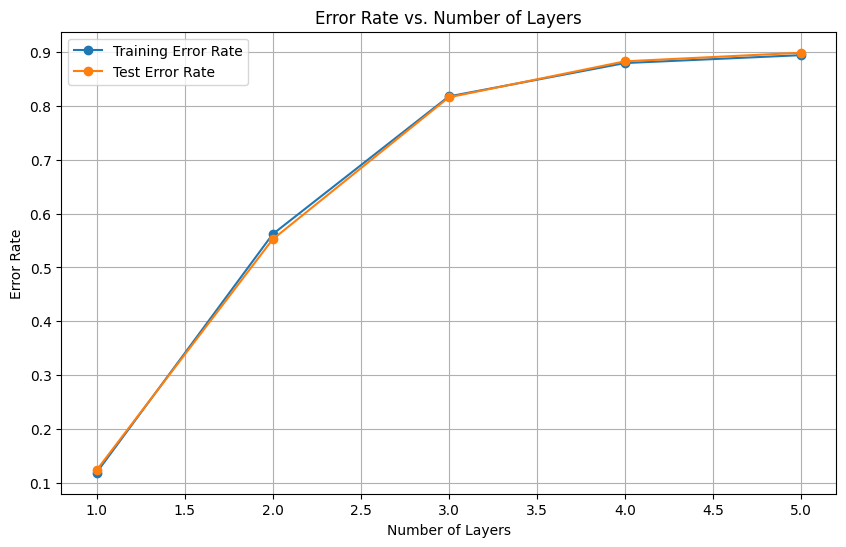

In [19]:
import matplotlib.pyplot as plt

# Load the error rates for each number of layers
num_layers = [1, 2, 3, 4, 5]
train_error_rates = []
test_error_rates = []

for n_layers in num_layers:
    train_error_rate_layer = load_object("layer_error_rate_train_" + str(n_layers) + ".pkl","../results/experiments_mnist")
    test_error_rate_layer = load_object("layer_error_rate_test_" + str(n_layers) + ".pkl","../results/experiments_mnist")
    
# Plotting the error rates
plt.figure(figsize=(10, 6))
plt.plot(num_layers, train_error_rate_layer, label='Training Error Rate', marker='o')
plt.plot(num_layers, test_error_rate_layer, label='Test Error Rate', marker='o')

plt.xlabel('Number of Layers')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Layers')
plt.legend()
plt.grid(True)
plt.show()


## 1.2. With pretraining

In [38]:
n_samples, n_visible = mnist_train.shape # n_samples, n_features
n_classes = mnist_test_labels.shape[1]

layer_loss = []
layer_error_rate_train = []
layer_error_rate_test = []
for n_layers in [1, 2, 3, 4, 5]:
    hidden_layer_sizes = [200] * n_layers
    dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
    # pretrain
    dnn.train(binary_mnist_train, n_epochs=10, learning_rate=3e-4, batch_size=512)

    loss = dnn.backpropagation(binary_mnist_train, labels=mnist_train_labels, n_epochs=10, learning_rate=3e-4, batch_size=512)
    layer_loss.append(loss)
    
    error_rate_train, _ = dnn.test(test_data=binary_mnist_train, true_labels=mnist_train_labels)
    layer_error_rate_train.append(error_rate_train)  # Assurez-vous que error_rate_train est un scalaire

    error_rate_test, _ = dnn.test(test_data=binary_mnist_test, true_labels=mnist_test_labels)
    layer_error_rate_test.append(error_rate_test)  # Assurez-vous que error_rate_test est un scalaire

    # Save the lists with losses and error rates
    save_object(layer_loss, "pretrain_layer_loss_" + str(n_layers) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_train, "pretrain_layer_error_rate_train_" + str(n_layers) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_test, "pretrain_layer_error_rate_test_" + str(n_layers) + ".pkl","../results/experiments_mnist")


Training:  10%|█         | 1/10 [00:01<00:16,  1.85s/epoch]

Epoch 1/10, Cross Entropy: 0.8996979715742415


Training:  20%|██        | 2/10 [00:03<00:15,  1.90s/epoch]

Epoch 2/10, Cross Entropy: 0.48527957869559246


Training:  30%|███       | 3/10 [00:05<00:13,  1.94s/epoch]

Epoch 3/10, Cross Entropy: 0.42390226865752856


Training:  40%|████      | 4/10 [00:07<00:11,  1.96s/epoch]

Epoch 4/10, Cross Entropy: 0.3961222321730684


Training:  50%|█████     | 5/10 [00:09<00:10,  2.01s/epoch]

Epoch 5/10, Cross Entropy: 0.37709963405282226


Training:  60%|██████    | 6/10 [00:11<00:08,  2.00s/epoch]

Epoch 6/10, Cross Entropy: 0.36399149947840953


Training:  70%|███████   | 7/10 [00:13<00:05,  1.98s/epoch]

Epoch 7/10, Cross Entropy: 0.35414625043590553


Training:  80%|████████  | 8/10 [00:15<00:03,  1.98s/epoch]

Epoch 8/10, Cross Entropy: 0.34725681231602895


Training:  90%|█████████ | 9/10 [00:17<00:01,  1.99s/epoch]

Epoch 9/10, Cross Entropy: 0.3423693295663131


Training: 100%|██████████| 10/10 [00:19<00:00,  1.97s/epoch]


Epoch 10/10, Cross Entropy: 0.336632307994012


Training:  10%|█         | 1/10 [00:02<00:24,  2.67s/epoch]

Epoch 1/10, Cross Entropy: 0.8772214460175016


Training:  20%|██        | 2/10 [00:05<00:21,  2.67s/epoch]

Epoch 2/10, Cross Entropy: 0.5243530106954507


Training:  30%|███       | 3/10 [00:07<00:18,  2.65s/epoch]

Epoch 3/10, Cross Entropy: 0.4710981109955882


Training:  40%|████      | 4/10 [00:10<00:15,  2.65s/epoch]

Epoch 4/10, Cross Entropy: 0.44509033307132284


Training:  50%|█████     | 5/10 [00:13<00:13,  2.65s/epoch]

Epoch 5/10, Cross Entropy: 0.4308405808627851


Training:  60%|██████    | 6/10 [00:15<00:10,  2.66s/epoch]

Epoch 6/10, Cross Entropy: 0.4192357373497189


Training:  70%|███████   | 7/10 [00:18<00:08,  2.68s/epoch]

Epoch 7/10, Cross Entropy: 0.4111889973269151


Training:  80%|████████  | 8/10 [00:21<00:05,  2.66s/epoch]

Epoch 8/10, Cross Entropy: 0.4063615499146549


Training:  90%|█████████ | 9/10 [00:23<00:02,  2.66s/epoch]

Epoch 9/10, Cross Entropy: 0.4020119168730995


Training: 100%|██████████| 10/10 [00:26<00:00,  2.66s/epoch]


Epoch 10/10, Cross Entropy: 0.39691786509293847


Training:  10%|█         | 1/10 [00:03<00:29,  3.32s/epoch]

Epoch 1/10, Cross Entropy: 0.9257598644102446


Training:  20%|██        | 2/10 [00:06<00:26,  3.35s/epoch]

Epoch 2/10, Cross Entropy: 0.5572708822339725


Training:  30%|███       | 3/10 [00:10<00:23,  3.34s/epoch]

Epoch 3/10, Cross Entropy: 0.507145797558574


Training:  40%|████      | 4/10 [00:13<00:20,  3.37s/epoch]

Epoch 4/10, Cross Entropy: 0.48832218318093434


Training:  50%|█████     | 5/10 [00:16<00:16,  3.36s/epoch]

Epoch 5/10, Cross Entropy: 0.4719037612587107


Training:  60%|██████    | 6/10 [00:20<00:13,  3.36s/epoch]

Epoch 6/10, Cross Entropy: 0.46553016286893156


Training:  70%|███████   | 7/10 [00:23<00:10,  3.35s/epoch]

Epoch 7/10, Cross Entropy: 0.45666163431663


Training:  80%|████████  | 8/10 [00:26<00:06,  3.38s/epoch]

Epoch 8/10, Cross Entropy: 0.45154204175731266


Training:  90%|█████████ | 9/10 [00:30<00:03,  3.35s/epoch]

Epoch 9/10, Cross Entropy: 0.4497041537729812


Training: 100%|██████████| 10/10 [00:33<00:00,  3.36s/epoch]


Epoch 10/10, Cross Entropy: 0.44547399396409443


Training:  10%|█         | 1/10 [00:03<00:35,  3.98s/epoch]

Epoch 1/10, Cross Entropy: 0.9336685816817912


Training:  20%|██        | 2/10 [00:08<00:32,  4.02s/epoch]

Epoch 2/10, Cross Entropy: 0.5996470331715051


Training:  30%|███       | 3/10 [00:12<00:28,  4.04s/epoch]

Epoch 3/10, Cross Entropy: 0.5561807072933681


Training:  40%|████      | 4/10 [00:16<00:24,  4.07s/epoch]

Epoch 4/10, Cross Entropy: 0.5358623589608048


Training:  50%|█████     | 5/10 [00:20<00:20,  4.09s/epoch]

Epoch 5/10, Cross Entropy: 0.5238229912621307


Training:  60%|██████    | 6/10 [00:24<00:16,  4.12s/epoch]

Epoch 6/10, Cross Entropy: 0.5153888560664395


Training:  70%|███████   | 7/10 [00:28<00:12,  4.09s/epoch]

Epoch 7/10, Cross Entropy: 0.5099022383199918


Training:  80%|████████  | 8/10 [00:32<00:08,  4.10s/epoch]

Epoch 8/10, Cross Entropy: 0.5071362549827441


Training:  90%|█████████ | 9/10 [00:36<00:04,  4.09s/epoch]

Epoch 9/10, Cross Entropy: 0.5027790553395112


Training: 100%|██████████| 10/10 [00:40<00:00,  4.09s/epoch]


Epoch 10/10, Cross Entropy: 0.4984448647183984


Training:  10%|█         | 1/10 [00:04<00:42,  4.69s/epoch]

Epoch 1/10, Cross Entropy: 0.9853921329982708


Training:  20%|██        | 2/10 [00:09<00:38,  4.79s/epoch]

Epoch 2/10, Cross Entropy: 0.6413244259100349


Training:  30%|███       | 3/10 [00:14<00:33,  4.82s/epoch]

Epoch 3/10, Cross Entropy: 0.59724939322297


Training:  40%|████      | 4/10 [00:19<00:28,  4.81s/epoch]

Epoch 4/10, Cross Entropy: 0.5802085722745923


Training:  50%|█████     | 5/10 [00:24<00:24,  4.82s/epoch]

Epoch 5/10, Cross Entropy: 0.5668357000177884


Training:  60%|██████    | 6/10 [00:28<00:19,  4.79s/epoch]

Epoch 6/10, Cross Entropy: 0.5606343399849427


Training:  70%|███████   | 7/10 [00:33<00:14,  4.80s/epoch]

Epoch 7/10, Cross Entropy: 0.5569267592640995


Training:  80%|████████  | 8/10 [00:38<00:09,  4.81s/epoch]

Epoch 8/10, Cross Entropy: 0.5555312556217282


Training:  90%|█████████ | 9/10 [00:43<00:04,  4.79s/epoch]

Epoch 9/10, Cross Entropy: 0.5490421347170815


Training: 100%|██████████| 10/10 [00:47<00:00,  4.79s/epoch]


Epoch 10/10, Cross Entropy: 0.5441831907899091


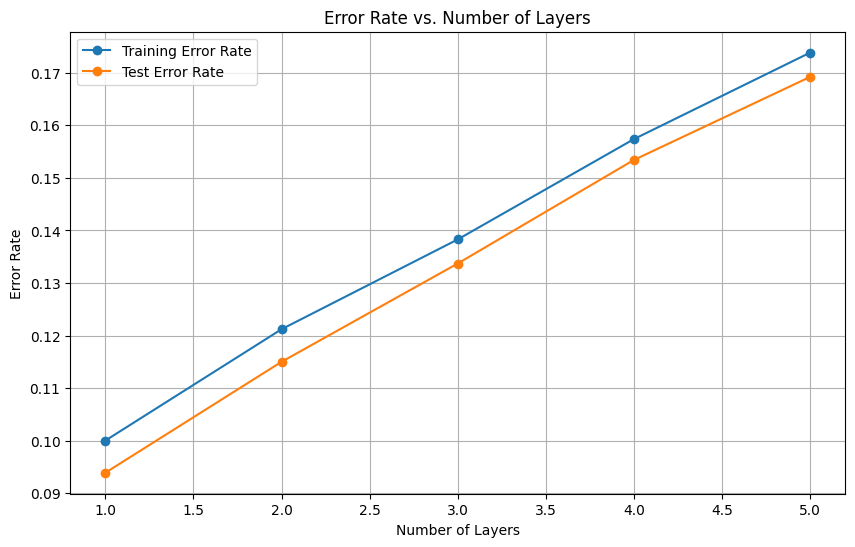

In [39]:
import matplotlib.pyplot as plt

# Load the error rates for each number of layers
num_layers = [1, 2, 3, 4, 5]
train_error_rates = []
test_error_rates = []

for n_layers in num_layers:
    train_error_rate_layer = load_object("pretrain_layer_error_rate_train_" + str(n_layers) + ".pkl","../results/experiments_mnist")
    test_error_rate_layer = load_object("pretrain_layer_error_rate_test_" + str(n_layers) + ".pkl","../results/experiments_mnist")
    
# Plotting the error rates
plt.figure(figsize=(10, 6))
plt.plot(num_layers, train_error_rate_layer, label='Training Error Rate', marker='o')
plt.plot(num_layers, test_error_rate_layer, label='Test Error Rate', marker='o')

plt.xlabel('Number of Layers')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Layers')
plt.legend()
plt.grid(True)
plt.show()


# 2.  number of neurons per layers

## 2.1. Without pretraining

In [41]:
n_samples, n_visible = mnist_train.shape # n_samples, n_features
n_classes = mnist_test_labels.shape[1]

neurons_per_layer = [100, 300, 500, 700]
layer_loss_neurons = []
layer_error_rate_train_neurons = []
layer_error_rate_test_neurons = []

for n_neurons in neurons_per_layer:
    hidden_layer_sizes = [n_neurons] * 2  # Fixer le nombre de couches à 2
    dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
    loss = dnn.backpropagation(binary_mnist_train, labels=mnist_train_labels, n_epochs=10, learning_rate=3e-4, batch_size=512)
    layer_loss_neurons.append(loss)
    
    error_rate_train, _ = dnn.test(test_data=binary_mnist_train, true_labels=mnist_train_labels)
    layer_error_rate_train_neurons.append(error_rate_train)  # Assurez-vous que error_rate_train est un scalaire

    error_rate_test, _ = dnn.test(test_data=binary_mnist_test, true_labels=mnist_test_labels)
    layer_error_rate_test_neurons.append(error_rate_test)  # Assurez-vous que error_rate_test est un scalaire

    # Save the lists with losses and error rates
    save_object(layer_loss_neurons, "layer_loss_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_train_neurons, "layer_error_rate_train_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_test_neurons, "layer_error_rate_test_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")


Training:  10%|█         | 1/10 [00:01<00:16,  1.86s/epoch]

Epoch 1/10, Cross Entropy: 2.362480259194659


Training:  20%|██        | 2/10 [00:03<00:15,  1.88s/epoch]

Epoch 2/10, Cross Entropy: 2.303130348354594


Training:  30%|███       | 3/10 [00:05<00:12,  1.84s/epoch]

Epoch 3/10, Cross Entropy: 2.277005887986886


Training:  40%|████      | 4/10 [00:07<00:11,  1.86s/epoch]

Epoch 4/10, Cross Entropy: 2.266685608902804


Training:  50%|█████     | 5/10 [00:09<00:09,  1.86s/epoch]

Epoch 5/10, Cross Entropy: 2.262026109459971


Training:  60%|██████    | 6/10 [00:11<00:07,  1.88s/epoch]

Epoch 6/10, Cross Entropy: 2.2599482845098797


Training:  70%|███████   | 7/10 [00:13<00:05,  1.86s/epoch]

Epoch 7/10, Cross Entropy: 2.2585363383455683


Training:  80%|████████  | 8/10 [00:15<00:03,  1.98s/epoch]

Epoch 8/10, Cross Entropy: 2.260722772450352


Training:  90%|█████████ | 9/10 [00:17<00:02,  2.03s/epoch]

Epoch 9/10, Cross Entropy: 2.2582668628161477


Training: 100%|██████████| 10/10 [00:19<00:00,  1.92s/epoch]


Epoch 10/10, Cross Entropy: 2.258815821474395


Training:  10%|█         | 1/10 [00:03<00:30,  3.43s/epoch]

Epoch 1/10, Cross Entropy: 2.4143874928280322


Training:  20%|██        | 2/10 [00:07<00:28,  3.53s/epoch]

Epoch 2/10, Cross Entropy: 2.187025970617257


Training:  30%|███       | 3/10 [00:10<00:24,  3.46s/epoch]

Epoch 3/10, Cross Entropy: 2.0982624775412027


Training:  40%|████      | 4/10 [00:13<00:20,  3.47s/epoch]

Epoch 4/10, Cross Entropy: 2.0580216983697595


Training:  50%|█████     | 5/10 [00:17<00:17,  3.46s/epoch]

Epoch 5/10, Cross Entropy: 2.0447232992053945


Training:  60%|██████    | 6/10 [00:20<00:13,  3.46s/epoch]

Epoch 6/10, Cross Entropy: 2.037631272986506


Training:  70%|███████   | 7/10 [00:24<00:10,  3.50s/epoch]

Epoch 7/10, Cross Entropy: 2.028953330193732


Training:  80%|████████  | 8/10 [00:28<00:07,  3.55s/epoch]

Epoch 8/10, Cross Entropy: 2.027270791225791


Training:  90%|█████████ | 9/10 [00:31<00:03,  3.49s/epoch]

Epoch 9/10, Cross Entropy: 2.0284196674494464


Training: 100%|██████████| 10/10 [00:34<00:00,  3.49s/epoch]


Epoch 10/10, Cross Entropy: 2.0227113804360632


Training:  10%|█         | 1/10 [00:04<00:43,  4.85s/epoch]

Epoch 1/10, Cross Entropy: 2.548518678417946


Training:  20%|██        | 2/10 [00:09<00:39,  4.95s/epoch]

Epoch 2/10, Cross Entropy: 2.153764256674477


Training:  30%|███       | 3/10 [00:14<00:34,  4.89s/epoch]

Epoch 3/10, Cross Entropy: 2.018097533308627


Training:  40%|████      | 4/10 [00:19<00:29,  4.91s/epoch]

Epoch 4/10, Cross Entropy: 1.91894261346049


Training:  50%|█████     | 5/10 [00:24<00:24,  4.92s/epoch]

Epoch 5/10, Cross Entropy: 1.8777400787846241


Training:  60%|██████    | 6/10 [00:29<00:19,  4.98s/epoch]

Epoch 6/10, Cross Entropy: 1.8714117026356836


Training:  70%|███████   | 7/10 [00:34<00:14,  4.94s/epoch]

Epoch 7/10, Cross Entropy: 1.8584894976612996


Training:  80%|████████  | 8/10 [00:39<00:09,  4.96s/epoch]

Epoch 8/10, Cross Entropy: 1.8459948004974387


Training:  90%|█████████ | 9/10 [00:44<00:04,  4.96s/epoch]

Epoch 9/10, Cross Entropy: 1.855550568395963


Training: 100%|██████████| 10/10 [00:49<00:00,  4.95s/epoch]


Epoch 10/10, Cross Entropy: 1.8345885692292536


Training:  10%|█         | 1/10 [00:06<00:57,  6.40s/epoch]

Epoch 1/10, Cross Entropy: 3.1222682959608195


Training:  20%|██        | 2/10 [00:12<00:51,  6.41s/epoch]

Epoch 2/10, Cross Entropy: 2.4196410109480353


Training:  30%|███       | 3/10 [00:19<00:44,  6.40s/epoch]

Epoch 3/10, Cross Entropy: 2.188166383141175


Training:  40%|████      | 4/10 [00:25<00:38,  6.40s/epoch]

Epoch 4/10, Cross Entropy: 2.023151241910357


Training:  50%|█████     | 5/10 [00:31<00:31,  6.39s/epoch]

Epoch 5/10, Cross Entropy: 1.96458846852894


Training:  60%|██████    | 6/10 [00:38<00:25,  6.39s/epoch]

Epoch 6/10, Cross Entropy: 1.887072706892094


Training:  70%|███████   | 7/10 [00:44<00:19,  6.39s/epoch]

Epoch 7/10, Cross Entropy: 1.8653320011184717


Training:  80%|████████  | 8/10 [00:51<00:12,  6.35s/epoch]

Epoch 8/10, Cross Entropy: 1.8681710574539567


Training:  90%|█████████ | 9/10 [00:57<00:06,  6.40s/epoch]

Epoch 9/10, Cross Entropy: 1.870900700612856


Training: 100%|██████████| 10/10 [01:03<00:00,  6.40s/epoch]

Epoch 10/10, Cross Entropy: 1.8589448976182728


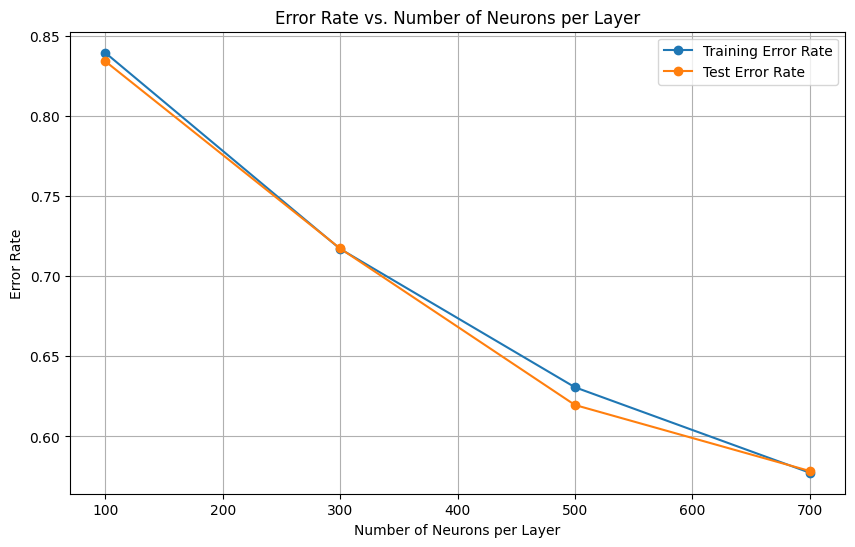

In [42]:
import matplotlib.pyplot as plt

# Load the error rates for each number of neurons per layer
neurons_per_layer = [100, 300, 500, 700]
train_error_rates_neurons = []
test_error_rates_neurons = []

for n_neurons in neurons_per_layer:
    train_error_rates_neurons = load_object("layer_error_rate_train_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    test_error_rates_neurons = load_object("layer_error_rate_test_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    

# Plotting the error rates for different numbers of neurons per layer
plt.figure(figsize=(10, 6))
plt.plot(neurons_per_layer, train_error_rates_neurons, label='Training Error Rate', marker='o')
plt.plot(neurons_per_layer, test_error_rates_neurons, label='Test Error Rate', marker='o')

plt.xlabel('Number of Neurons per Layer')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Neurons per Layer')
plt.legend()
plt.grid(True)
plt.show()


## 2.2. With pretraining

In [43]:
n_samples, n_visible = mnist_train.shape # n_samples, n_features
n_classes = mnist_test_labels.shape[1]

neurons_per_layer = [100, 300, 500, 700]
layer_loss_neurons = []
layer_error_rate_train_neurons = []
layer_error_rate_test_neurons = []

for n_neurons in neurons_per_layer:
    hidden_layer_sizes = [n_neurons] * 2  # Fixer le nombre de couches à 2
    dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
    
    # pretrain
    dnn.train(mnist_train, n_epochs=10, learning_rate=3e-4, batch_size=512)
    
    loss = dnn.backpropagation(binary_mnist_train, labels=mnist_train_labels, n_epochs=10, learning_rate=3e-4, batch_size=512)
    layer_loss_neurons.append(loss)
    
    error_rate_train, _ = dnn.test(test_data=binary_mnist_train, true_labels=mnist_train_labels)
    layer_error_rate_train_neurons.append(error_rate_train)  # Assurez-vous que error_rate_train est un scalaire

    error_rate_test, _ = dnn.test(test_data=binary_mnist_test, true_labels=mnist_test_labels)
    layer_error_rate_test_neurons.append(error_rate_test)  # Assurez-vous que error_rate_test est un scalaire

    # Save the lists with losses and error rates
    save_object(layer_loss_neurons, "pretrain_layer_loss_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_train_neurons, "pretrain_layer_error_rate_train_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_test_neurons, "pretrain_layer_error_rate_test_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")


Training RBM layers:   0%|          | 0/2 [00:00<?, ?layer/s]c:\Users\choho\Desktop\Master DS\Deep learning II\github\DeepLearning2-Project-M2DS\src\functionals.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
Training:  10%|█         | 1/10 [00:01<00:15,  1.72s/epoch]

Epoch 1/10, Cross Entropy: 2.3336797611999724


Training:  20%|██        | 2/10 [00:03<00:13,  1.75s/epoch]

Epoch 2/10, Cross Entropy: 2.323047757946269


Training:  30%|███       | 3/10 [00:05<00:12,  1.73s/epoch]

Epoch 3/10, Cross Entropy: 2.3246958989758366


Training:  40%|████      | 4/10 [00:07<00:10,  1.78s/epoch]

Epoch 4/10, Cross Entropy: 2.322452362700704


Training:  50%|█████     | 5/10 [00:08<00:08,  1.79s/epoch]

Epoch 5/10, Cross Entropy: 2.3204846571553204


Training:  60%|██████    | 6/10 [00:10<00:07,  1.82s/epoch]

Epoch 6/10, Cross Entropy: 2.319820097466143


Training:  70%|███████   | 7/10 [00:12<00:05,  1.77s/epoch]

Epoch 7/10, Cross Entropy: 2.3208194733682275


Training:  80%|████████  | 8/10 [00:14<00:03,  1.79s/epoch]

Epoch 8/10, Cross Entropy: 2.3215832318765135


Training:  90%|█████████ | 9/10 [00:15<00:01,  1.78s/epoch]

Epoch 9/10, Cross Entropy: 2.3245205880140416


Training: 100%|██████████| 10/10 [00:17<00:00,  1.79s/epoch]


Epoch 10/10, Cross Entropy: 2.3233198484585134


Training:  10%|█         | 1/10 [00:03<00:27,  3.05s/epoch]

Epoch 1/10, Cross Entropy: 4.044568282055888


Training:  20%|██        | 2/10 [00:06<00:24,  3.11s/epoch]

Epoch 2/10, Cross Entropy: 4.115989077057136


Training:  30%|███       | 3/10 [00:09<00:21,  3.10s/epoch]

Epoch 3/10, Cross Entropy: 4.3047569686825575


Training:  40%|████      | 4/10 [00:12<00:18,  3.13s/epoch]

Epoch 4/10, Cross Entropy: 4.23439198786972


Training:  50%|█████     | 5/10 [00:15<00:15,  3.16s/epoch]

Epoch 5/10, Cross Entropy: 4.132031220931409


Training:  60%|██████    | 6/10 [00:18<00:12,  3.14s/epoch]

Epoch 6/10, Cross Entropy: 4.033934706508113


Training:  70%|███████   | 7/10 [00:21<00:09,  3.16s/epoch]

Epoch 7/10, Cross Entropy: 4.081790063070603


Training:  80%|████████  | 8/10 [00:25<00:06,  3.14s/epoch]

Epoch 8/10, Cross Entropy: 4.173525541327632


Training:  90%|█████████ | 9/10 [00:28<00:03,  3.16s/epoch]

Epoch 9/10, Cross Entropy: 4.179385378684917


Training: 100%|██████████| 10/10 [00:31<00:00,  3.13s/epoch]


Epoch 10/10, Cross Entropy: 4.096481771765875


Training:  10%|█         | 1/10 [00:04<00:41,  4.63s/epoch]

Epoch 1/10, Cross Entropy: 12.196672508967689


Training:  20%|██        | 2/10 [00:09<00:37,  4.74s/epoch]

Epoch 2/10, Cross Entropy: 12.713913230304893


Training:  30%|███       | 3/10 [00:14<00:32,  4.70s/epoch]

Epoch 3/10, Cross Entropy: 12.0329605389928


Training:  40%|████      | 4/10 [00:18<00:28,  4.72s/epoch]

Epoch 4/10, Cross Entropy: 11.49412207863624


Training:  50%|█████     | 5/10 [00:23<00:23,  4.67s/epoch]

Epoch 5/10, Cross Entropy: 12.737555997362447


Training:  60%|██████    | 6/10 [00:28<00:18,  4.70s/epoch]

Epoch 6/10, Cross Entropy: 12.684297068504105


Training:  70%|███████   | 7/10 [00:32<00:14,  4.68s/epoch]

Epoch 7/10, Cross Entropy: 11.922505365980843


Training:  80%|████████  | 8/10 [00:37<00:09,  4.69s/epoch]

Epoch 8/10, Cross Entropy: 12.631387271725298


Training:  90%|█████████ | 9/10 [00:42<00:04,  4.65s/epoch]

Epoch 9/10, Cross Entropy: 12.599451229458998


Training: 100%|██████████| 10/10 [00:46<00:00,  4.69s/epoch]


Epoch 10/10, Cross Entropy: 11.927951757440264


Training:  10%|█         | 1/10 [00:05<00:51,  5.76s/epoch]

Epoch 1/10, Cross Entropy: 18.94345144646524


Training:  20%|██        | 2/10 [00:11<00:47,  5.92s/epoch]

Epoch 2/10, Cross Entropy: 17.763659813448204


Training:  30%|███       | 3/10 [00:17<00:41,  5.92s/epoch]

Epoch 3/10, Cross Entropy: 19.596010957857626


Training:  40%|████      | 4/10 [00:23<00:35,  5.95s/epoch]

Epoch 4/10, Cross Entropy: 18.283209546369978


Training:  50%|█████     | 5/10 [00:29<00:29,  5.95s/epoch]

Epoch 5/10, Cross Entropy: 19.08526179855331


Training:  60%|██████    | 6/10 [00:35<00:24,  6.02s/epoch]

Epoch 6/10, Cross Entropy: 18.106080104576908


Training:  70%|███████   | 7/10 [00:41<00:17,  5.99s/epoch]

Epoch 7/10, Cross Entropy: 18.73488785252841


Training:  80%|████████  | 8/10 [00:47<00:12,  6.03s/epoch]

Epoch 8/10, Cross Entropy: 19.15761055531007


Training:  90%|█████████ | 9/10 [00:53<00:06,  6.00s/epoch]

Epoch 9/10, Cross Entropy: 18.597885971594707


Training: 100%|██████████| 10/10 [00:59<00:00,  6.00s/epoch]


Epoch 10/10, Cross Entropy: 19.96200808477518


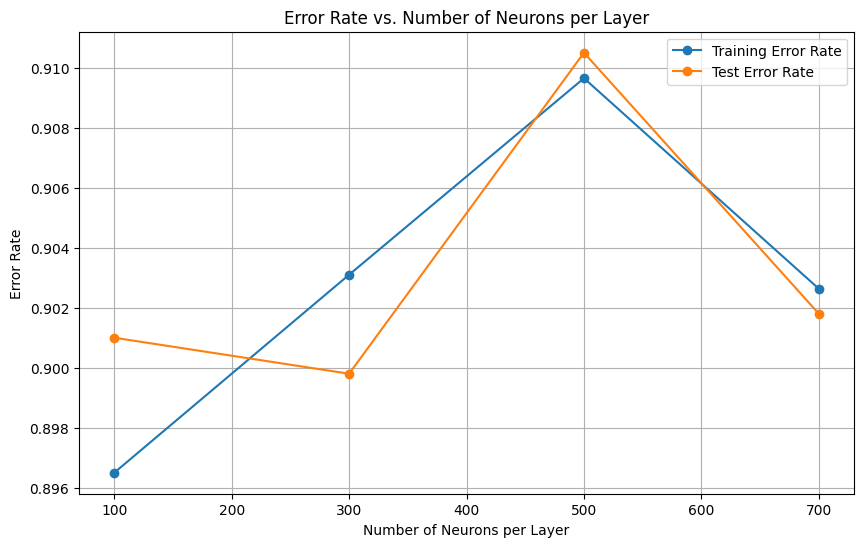

In [44]:
import matplotlib.pyplot as plt

# Load the error rates for each number of neurons per layer
neurons_per_layer = [100, 300, 500, 700]
train_error_rates_neurons = []
test_error_rates_neurons = []

for n_neurons in neurons_per_layer:
    train_error_rates_neurons = load_object("pretrain_layer_error_rate_train_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    test_error_rates_neurons = load_object("pretrain_layer_error_rate_test_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    

# Plotting the error rates for different numbers of neurons per layer
plt.figure(figsize=(10, 6))
plt.plot(neurons_per_layer, train_error_rates_neurons, label='Training Error Rate', marker='o')
plt.plot(neurons_per_layer, test_error_rates_neurons, label='Test Error Rate', marker='o')

plt.xlabel('Number of Neurons per Layer')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Neurons per Layer')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
dnn.test(binary_mnist_test, mnist_test_labels)

(0.9018,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

# 3.  As a function of the number of data trains 

## 3.1. Without pretraining

In [47]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm



def create_stratified_subset(data, labels, num_samples_per_class):
    """
    Create a stratified subset of the dataset ensuring each class is represented equally.

    Parameters:
    - data (np.ndarray): The dataset.
    - labels (np.ndarray): The labels for the dataset.
    - num_samples_per_class (int): Number of samples per class.

    Returns:
    - subset_data (np.ndarray): Stratified subset of the dataset.
    - subset_labels (np.ndarray): Labels for the stratified subset.
    """
    unique_classes = np.unique(labels)
    subset_data = []
    subset_labels = []

    for cls in unique_classes:
        class_indices = np.where(labels == cls)[0]
        selected_indices = class_indices[:num_samples_per_class]
        subset_data.append(data[selected_indices])
        subset_labels.append(labels[selected_indices])

    subset_data = np.concatenate(subset_data, axis=0)
    subset_labels = np.concatenate(subset_labels, axis=0)

    return subset_data, subset_labels


In [48]:
n_samples, n_visible = mnist_train.shape  # n_samples, n_features
n_classes = mnist_test_labels.shape[1]

# Defining different sizes for the subsets ensuring equal representation for each class
data_sizes = [1000, 3000, 7000, 10000, 30000, 60000]
num_classes = len(np.unique(mnist_train_labels))
layer_loss_data = []
layer_error_rate_train_data = []
layer_error_rate_test_data = []

for data_size in data_sizes:
    num_samples_per_class = data_size // num_classes
    subset_train_data, subset_train_labels = create_stratified_subset(binary_mnist_train, mnist_train_labels, num_samples_per_class)
    
    hidden_layer_sizes = [200] * 2  # Fixer le nombre de couches à 2 avec 200 neurones chacune
    dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
    loss = dnn.backpropagation(subset_train_data, labels=subset_train_labels, n_epochs=10, learning_rate=3e-4, batch_size=512)
    layer_loss_data.append(loss)
    
    error_rate_train, _ = dnn.test(test_data=subset_train_data, true_labels=subset_train_labels)
    layer_error_rate_train_data.append(error_rate_train)  # Assurez-vous que error_rate_train est un scalaire

    error_rate_test, _ = dnn.test(test_data=binary_mnist_test, true_labels=mnist_test_labels)
    layer_error_rate_test_data.append(error_rate_test)  # Assurez-vous que error_rate_test est un scalaire

    # Save the lists with losses and error rates
    save_object(layer_loss_data, "number_loss_data_" + str(data_size) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_train_data, "number_error_rate_train_data_" + str(data_size) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_test_data, "number_error_rate_test_data_" + str(data_size) + ".pkl","../results/experiments_mnist")


Training:  50%|█████     | 5/10 [00:00<00:00, 22.50epoch/s]

Epoch 1/10, Cross Entropy: 1.7666896694481529
Epoch 2/10, Cross Entropy: 0.0027883054114978345
Epoch 3/10, Cross Entropy: 0.0027252581521652695
Epoch 4/10, Cross Entropy: 0.0025955230205314565
Epoch 5/10, Cross Entropy: 0.0024723290462020063


Training: 100%|██████████| 10/10 [00:00<00:00, 23.14epoch/s]


Epoch 6/10, Cross Entropy: 0.002356637336748873
Epoch 7/10, Cross Entropy: 0.0022423199699246536
Epoch 8/10, Cross Entropy: 0.002229973853257036
Epoch 9/10, Cross Entropy: 0.002038006929015805
Epoch 10/10, Cross Entropy: 0.002053268087986075


Training:  20%|██        | 2/10 [00:00<00:00,  9.07epoch/s]

Epoch 1/10, Cross Entropy: 0.828207569876666
Epoch 2/10, Cross Entropy: 0.006069981526832577


Training:  40%|████      | 4/10 [00:00<00:00,  7.57epoch/s]

Epoch 3/10, Cross Entropy: 0.004520534432657311
Epoch 4/10, Cross Entropy: 0.003669057039663009


Training:  60%|██████    | 6/10 [00:00<00:00,  8.22epoch/s]

Epoch 5/10, Cross Entropy: 0.0030799041288766186
Epoch 6/10, Cross Entropy: 0.0026550991751551965


Training:  80%|████████  | 8/10 [00:00<00:00,  8.52epoch/s]

Epoch 7/10, Cross Entropy: 0.002323278112452075
Epoch 8/10, Cross Entropy: 0.0020084591412159332


Training: 100%|██████████| 10/10 [00:01<00:00,  8.34epoch/s]


Epoch 9/10, Cross Entropy: 0.0018481275071579963
Epoch 10/10, Cross Entropy: 0.0015840833802827218


Training:  10%|█         | 1/10 [00:00<00:02,  3.52epoch/s]

Epoch 1/10, Cross Entropy: 0.17244033236258086


Training:  20%|██        | 2/10 [00:00<00:02,  3.75epoch/s]

Epoch 2/10, Cross Entropy: 0.0018122748072046486


Training:  30%|███       | 3/10 [00:00<00:01,  3.84epoch/s]

Epoch 3/10, Cross Entropy: 0.001524275399639011


Training:  40%|████      | 4/10 [00:01<00:01,  3.85epoch/s]

Epoch 4/10, Cross Entropy: 0.0012441673117740781


Training:  50%|█████     | 5/10 [00:01<00:01,  3.88epoch/s]

Epoch 5/10, Cross Entropy: 0.0010876657440413943


Training:  60%|██████    | 6/10 [00:01<00:01,  3.97epoch/s]

Epoch 6/10, Cross Entropy: 0.0009771038578328137


Training:  70%|███████   | 7/10 [00:01<00:00,  3.97epoch/s]

Epoch 7/10, Cross Entropy: 0.00087233692650461


Training:  80%|████████  | 8/10 [00:02<00:00,  3.95epoch/s]

Epoch 8/10, Cross Entropy: 0.000783453403154823


Training:  90%|█████████ | 9/10 [00:02<00:00,  3.77epoch/s]

Epoch 9/10, Cross Entropy: 0.0007312770095096625


Training: 100%|██████████| 10/10 [00:02<00:00,  3.84epoch/s]


Epoch 10/10, Cross Entropy: 0.0006482532482865844


Training:  10%|█         | 1/10 [00:00<00:03,  2.68epoch/s]

Epoch 1/10, Cross Entropy: 0.0710653782442018


Training:  20%|██        | 2/10 [00:00<00:02,  2.68epoch/s]

Epoch 2/10, Cross Entropy: 0.0020616204296808574


Training:  30%|███       | 3/10 [00:01<00:02,  2.73epoch/s]

Epoch 3/10, Cross Entropy: 0.0014710010076154842


Training:  40%|████      | 4/10 [00:01<00:02,  2.68epoch/s]

Epoch 4/10, Cross Entropy: 0.0011961785910237774


Training:  50%|█████     | 5/10 [00:01<00:01,  2.70epoch/s]

Epoch 5/10, Cross Entropy: 0.0009964270372915974


Training:  60%|██████    | 6/10 [00:02<00:01,  2.75epoch/s]

Epoch 6/10, Cross Entropy: 0.0008308718755056206


Training:  70%|███████   | 7/10 [00:02<00:01,  2.66epoch/s]

Epoch 7/10, Cross Entropy: 0.0007434132577743004


Training:  80%|████████  | 8/10 [00:03<00:00,  2.58epoch/s]

Epoch 8/10, Cross Entropy: 0.0006406131551621244


Training:  90%|█████████ | 9/10 [00:03<00:00,  2.64epoch/s]

Epoch 9/10, Cross Entropy: 0.0005874577079824331


Training: 100%|██████████| 10/10 [00:03<00:00,  2.64epoch/s]


Epoch 10/10, Cross Entropy: 0.0005229344415146368


Training:  10%|█         | 1/10 [00:01<00:09,  1.07s/epoch]

Epoch 1/10, Cross Entropy: 0.9834786564024465


Training:  20%|██        | 2/10 [00:02<00:08,  1.06s/epoch]

Epoch 2/10, Cross Entropy: 0.8146198129702926


Training:  30%|███       | 3/10 [00:03<00:07,  1.08s/epoch]

Epoch 3/10, Cross Entropy: 0.7435477408439323


Training:  40%|████      | 4/10 [00:04<00:06,  1.05s/epoch]

Epoch 4/10, Cross Entropy: 0.6742723856557442


Training:  50%|█████     | 5/10 [00:05<00:05,  1.05s/epoch]

Epoch 5/10, Cross Entropy: 0.6787308079657267


Training:  60%|██████    | 6/10 [00:06<00:04,  1.04s/epoch]

Epoch 6/10, Cross Entropy: 0.6661325816368681


Training:  70%|███████   | 7/10 [00:07<00:03,  1.05s/epoch]

Epoch 7/10, Cross Entropy: 0.6678136593970901


Training:  80%|████████  | 8/10 [00:08<00:02,  1.05s/epoch]

Epoch 8/10, Cross Entropy: 0.684099296900581


Training:  90%|█████████ | 9/10 [00:09<00:01,  1.06s/epoch]

Epoch 9/10, Cross Entropy: 0.6665007922808507


Training: 100%|██████████| 10/10 [00:10<00:00,  1.06s/epoch]


Epoch 10/10, Cross Entropy: 0.6736987552015408


Training:  10%|█         | 1/10 [00:02<00:18,  2.08s/epoch]

Epoch 1/10, Cross Entropy: 1.4208254183670967


Training:  20%|██        | 2/10 [00:04<00:16,  2.07s/epoch]

Epoch 2/10, Cross Entropy: 1.2123885830277488


Training:  30%|███       | 3/10 [00:06<00:14,  2.07s/epoch]

Epoch 3/10, Cross Entropy: 1.13055033556808


Training:  40%|████      | 4/10 [00:08<00:12,  2.04s/epoch]

Epoch 4/10, Cross Entropy: 1.1028243753607183


Training:  50%|█████     | 5/10 [00:10<00:10,  2.05s/epoch]

Epoch 5/10, Cross Entropy: 1.121000060820997


Training:  60%|██████    | 6/10 [00:12<00:08,  2.04s/epoch]

Epoch 6/10, Cross Entropy: 1.1177891263215318


Training:  70%|███████   | 7/10 [00:14<00:06,  2.05s/epoch]

Epoch 7/10, Cross Entropy: 1.1055548090676433


Training:  80%|████████  | 8/10 [00:16<00:04,  2.05s/epoch]

Epoch 8/10, Cross Entropy: 1.0957841427821533


Training:  90%|█████████ | 9/10 [00:18<00:02,  2.09s/epoch]

Epoch 9/10, Cross Entropy: 1.1148256721549052


Training: 100%|██████████| 10/10 [00:20<00:00,  2.08s/epoch]


Epoch 10/10, Cross Entropy: 1.1138767851342757


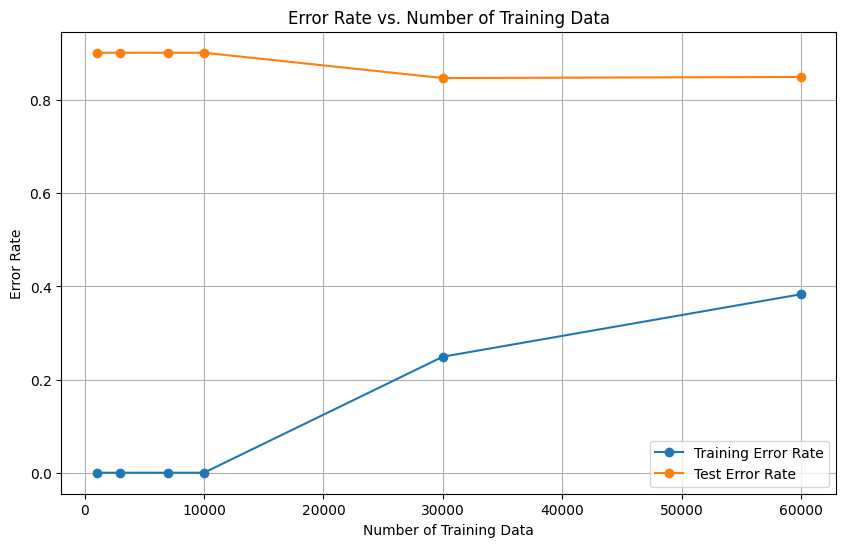

In [49]:
# Load the error rates for each data size
data_sizes = [1000, 3000, 7000, 10000, 30000, 60000]
train_error_rates_data = []
test_error_rates_data = []

for data_size in data_sizes:
    train_error_rates_data = load_object("number_error_rate_train_data_" + str(data_size) + ".pkl","../results/experiments_mnist")
    test_error_rates_data = load_object("number_error_rate_test_data_" + str(data_size) + ".pkl","../results/experiments_mnist")
    
# Plotting the error rates for different numbers of training data
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, train_error_rates_data, label='Training Error Rate', marker='o')
plt.plot(data_sizes, test_error_rates_data, label='Test Error Rate', marker='o')

plt.xlabel('Number of Training Data')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Training Data')
plt.legend()
plt.grid(True)
plt.show()


## 3.2. With pretraining

In [ ]:
n_samples, n_visible = mnist_train.shape  # n_samples, n_features
n_classes = mnist_test_labels.shape[1]

# Defining different sizes for the subsets ensuring equal representation for each class
data_sizes = [1000, 3000, 7000, 10000, 30000, 60000]
num_classes = len(np.unique(mnist_train_labels))
layer_loss_data = []
layer_error_rate_train_data = []
layer_error_rate_test_data = []

for data_size in data_sizes:
    num_samples_per_class = data_size // num_classes
    subset_train_data, subset_train_labels = create_stratified_subset(binary_mnist_train, mnist_train_labels, num_samples_per_class)
    
    hidden_layer_sizes = [200] * 2  # Fixer le nombre de couches à 2 avec 200 neurones chacune
    dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)

    # pretrain
    dnn.train(binary_mnist_train, n_epochs=500, learning_rate=3e-4, batch_size=512)

    loss = dnn.backpropagation(subset_train_data, labels=subset_train_labels, n_epochs=100, learning_rate=3e-4, batch_size=512)
    layer_loss_data.append(loss)
    
    error_rate_train, _ = dnn.test(test_data=subset_train_data, true_labels=subset_train_labels)
    layer_error_rate_train_data.append(error_rate_train)  # Assurez-vous que error_rate_train est un scalaire

    error_rate_test, _ = dnn.test(test_data=binary_mnist_test, true_labels=mnist_test_labels)
    layer_error_rate_test_data.append(error_rate_test)  # Assurez-vous que error_rate_test est un scalaire

    # Save the lists with losses and error rates
    save_object(layer_loss_data, "pretrain_number_loss_data_" + str(data_size) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_train_data, "pretrain_number_error_rate_train_data_" + str(data_size) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_test_data, "pretrain_number_error_rate_test_data_" + str(data_size) + ".pkl","../results/experiments_mnist")


Training RBM layers:   0%|          | 0/2 [00:00<?, ?layer/s]c:\Users\choho\Desktop\Master DS\Deep learning II\github\DeepLearning2-Project-M2DS\src\functionals.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
Training: 100%|██████████| 2/2 [00:00<00:00, 32.09epoch/s]


Epoch 1/2, Cross Entropy: 1.7431534944897862
Epoch 2/2, Cross Entropy: 2.816259136315084e-10


Training: 100%|██████████| 2/2 [00:00<00:00, 10.47epoch/s]


Epoch 1/2, Cross Entropy: 0.5628737306218816
Epoch 2/2, Cross Entropy: 1.6347324565810695e-10


Training:  50%|█████     | 1/2 [00:00<00:00,  4.27epoch/s]

Epoch 1/2, Cross Entropy: 0.1504961329616406


Training: 100%|██████████| 2/2 [00:00<00:00,  4.40epoch/s]


Epoch 2/2, Cross Entropy: 5.332633198436142e-10


Training:  50%|█████     | 1/2 [00:00<00:00,  3.13epoch/s]

Epoch 1/2, Cross Entropy: 0.11700404710500936


Training: 100%|██████████| 2/2 [00:00<00:00,  3.10epoch/s]


Epoch 2/2, Cross Entropy: 3.967729347698922e-10


Training:  50%|█████     | 1/2 [00:01<00:01,  1.07s/epoch]

Epoch 1/2, Cross Entropy: 4.792119086608687


Training: 100%|██████████| 2/2 [00:02<00:00,  1.09s/epoch]


Epoch 2/2, Cross Entropy: 4.427701403990591


Training:  50%|█████     | 1/2 [00:02<00:02,  2.10s/epoch]

Epoch 1/2, Cross Entropy: 4.924126432877398


Training: 100%|██████████| 2/2 [00:04<00:00,  2.06s/epoch]


Epoch 2/2, Cross Entropy: 4.3343469536504236


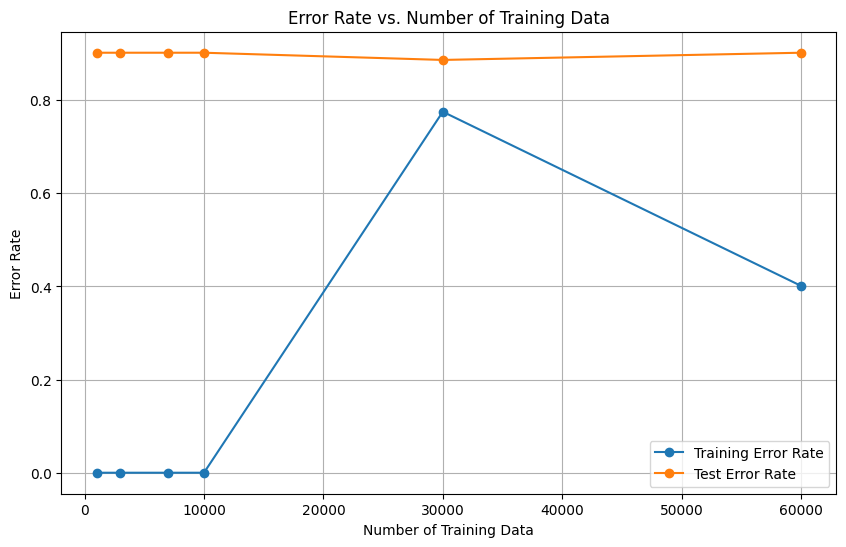

In [ ]:
# Load the error rates for each data size
data_sizes = [1000, 3000, 7000, 10000, 30000, 60000]
train_error_rates_data = []
test_error_rates_data = []

for data_size in data_sizes:
    train_error_rates_data = load_object("pretrain_number_error_rate_train_data_" + str(data_size) + ".pkl", "../results/experiments_mnist")
    test_error_rates_data = load_object("pretrain_number_error_rate_test_data_" + str(data_size) + ".pkl", "../results/experiments_mnist")
    
# Plotting the error rates for different numbers of training data
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, train_error_rates_data, label='Training Error Rate', marker='o')
plt.plot(data_sizes, test_error_rates_data, label='Test Error Rate', marker='o')

plt.xlabel('Number of Training Data')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Training Data')
plt.legend()
plt.grid(True)
plt.show()
